In [1]:
## Initialzing and loading required libraries and subfunctions
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

sns.set(style='white', context='notebook')

In [2]:
import sys
print(sys.executable)

F:\app\anaconda\python.exe


In [3]:
path_to_hpc = "C:/Users/pc/Data_pipeline_project/mani-data-example/mani-data-example/2018-11-05_14-15-28_Post_Trial5/HPC_100_CH32_0.continuous.mat"
path_to_states = "C:/Users/pc/Data_pipeline_project/mani-data-example/mani-data-example/2018-11-05_14-15-28_Post_Trial5/2018-11-05_14-15-28_post_trial5-states.mat"

In [6]:
config = emd.sift.SiftConfig.from_yaml_file(
    r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\emd_masksift_CA1_config_2500.yml"
)

In [7]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)

There was 0 in the dataset


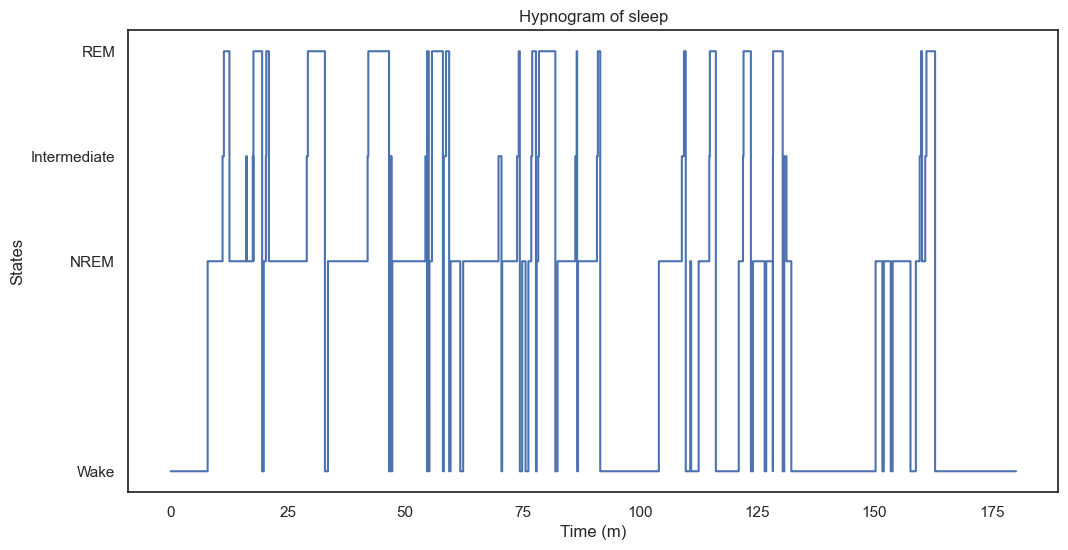

In [26]:
plot_hypnogram(hypno)

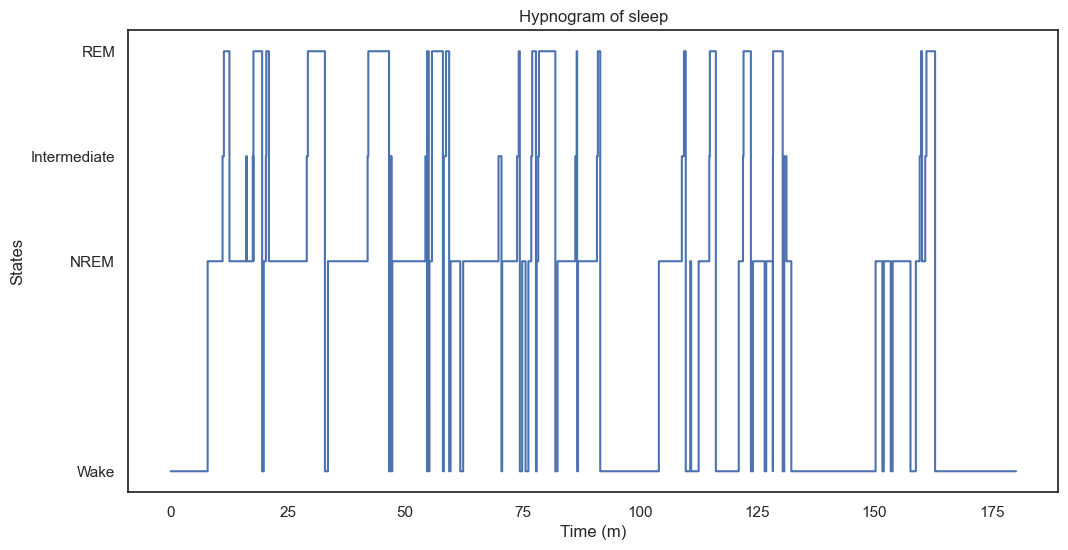

In [8]:
plot_hypnogram(hypno)

In [9]:
np.unique(hypno)

array([1, 3, 4, 5], dtype=uint8)

In [10]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [14]:
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)
# i think amir output was 54

Number of detected Tonic intrevals:53
Number of detected Tonic intrevals after threshold:53


In [15]:
len(phasic_interval)
# amir output was 35

34

In [16]:
def get_cycle_data(imf5, fs=2500):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [17]:
def extract_imfs_by_pt_intervals(lfp, fs, interval, config, return_imfs_freqs=False):

    all_imfs = []
    all_imf_freqs = []
    rem_lfp = []
    all_masked_freqs = []
    for ii in range(len(interval)):
        start_idx = int(interval.loc[ii, 'start'] * fs)
        end_idx = int(interval.loc[ii, 'end'] * fs)
        sig_part = lfp[start_idx:end_idx]
        sig = np.array(sig_part)

        rem_lfp.append(sig)

        try:
            imf, mask_freq = sift.mask_sift(sig, **config)
        except Exception as e:
            print(f"EMD Sift failed: {e}. Skipping this interval.")
            continue
        all_imfs.append(imf)
        all_masked_freqs.append(mask_freq)

        imf_frequencies = imf_freq(imf, fs)
        all_imf_freqs.append(imf_frequencies)

    if return_imfs_freqs:
        return all_imfs, all_imf_freqs, rem_lfp
    else:
        return all_imfs

In [21]:
tonic_imfs, tonic_imfs_freqs, tonic_rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, tonic_interval, config, return_imfs_freqs=True)

In [22]:
phasic_imfs, phasic_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, phasic_interval, config, return_imfs_freqs=True)

In [19]:
def extract_cycle_info(imfs, imf_frequencies):

  all_FPPs = []
  all_cycles_se =[]
  all_cycles_ctrl = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']

    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    ctrl = emd.cycles.get_control_points(imf[:, 5], cycle_data['cycles'], mode='augmented')
    cycle_ctrls = get_cycle_ctrl(ctrl, subset_indices)
    all_cycles_ctrl.append(cycle_ctrls)
    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    all_cycles_se.append(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

  return all_cycles_ctrl, all_cycles_se, all_FPPs

In [15]:
all_phasic_cycle_ctrls, all_phasic_cycles_se, all_phasic_FPPs = extract_cycle_info(phasic_imfs, phasic_imfs_freqs)
all_tonic_cycle_ctrls, all_tonic_cycles_se, all_tonic_FPPs = extract_cycle_info(tonic_imfs, tonic_imfs_freqs)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs 

In [23]:
all_phasic_cycle_ctrls, all_phasic_cycles_se, all_phasic_FPPs = extract_cycle_info(phasic_imfs, phasic_imfs_freqs)
all_tonic_cycle_ctrls, all_tonic_cycles_se, all_tonic_FPPs = extract_cycle_info(tonic_imfs, tonic_imfs_freqs)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs 

In [24]:
frequencies = np.arange(15, 141, 1)
angles = np.linspace(-180, 180, 19)

In [25]:
FPP = all_phasic_FPPs[0]
all_cycles_inds = all_phasic_cycles_se[0]
all_cycles_ctrl = all_phasic_cycle_ctrls[0]
imf = phasic_imfs[0]
firstRemLFP = rem_lpf[0]

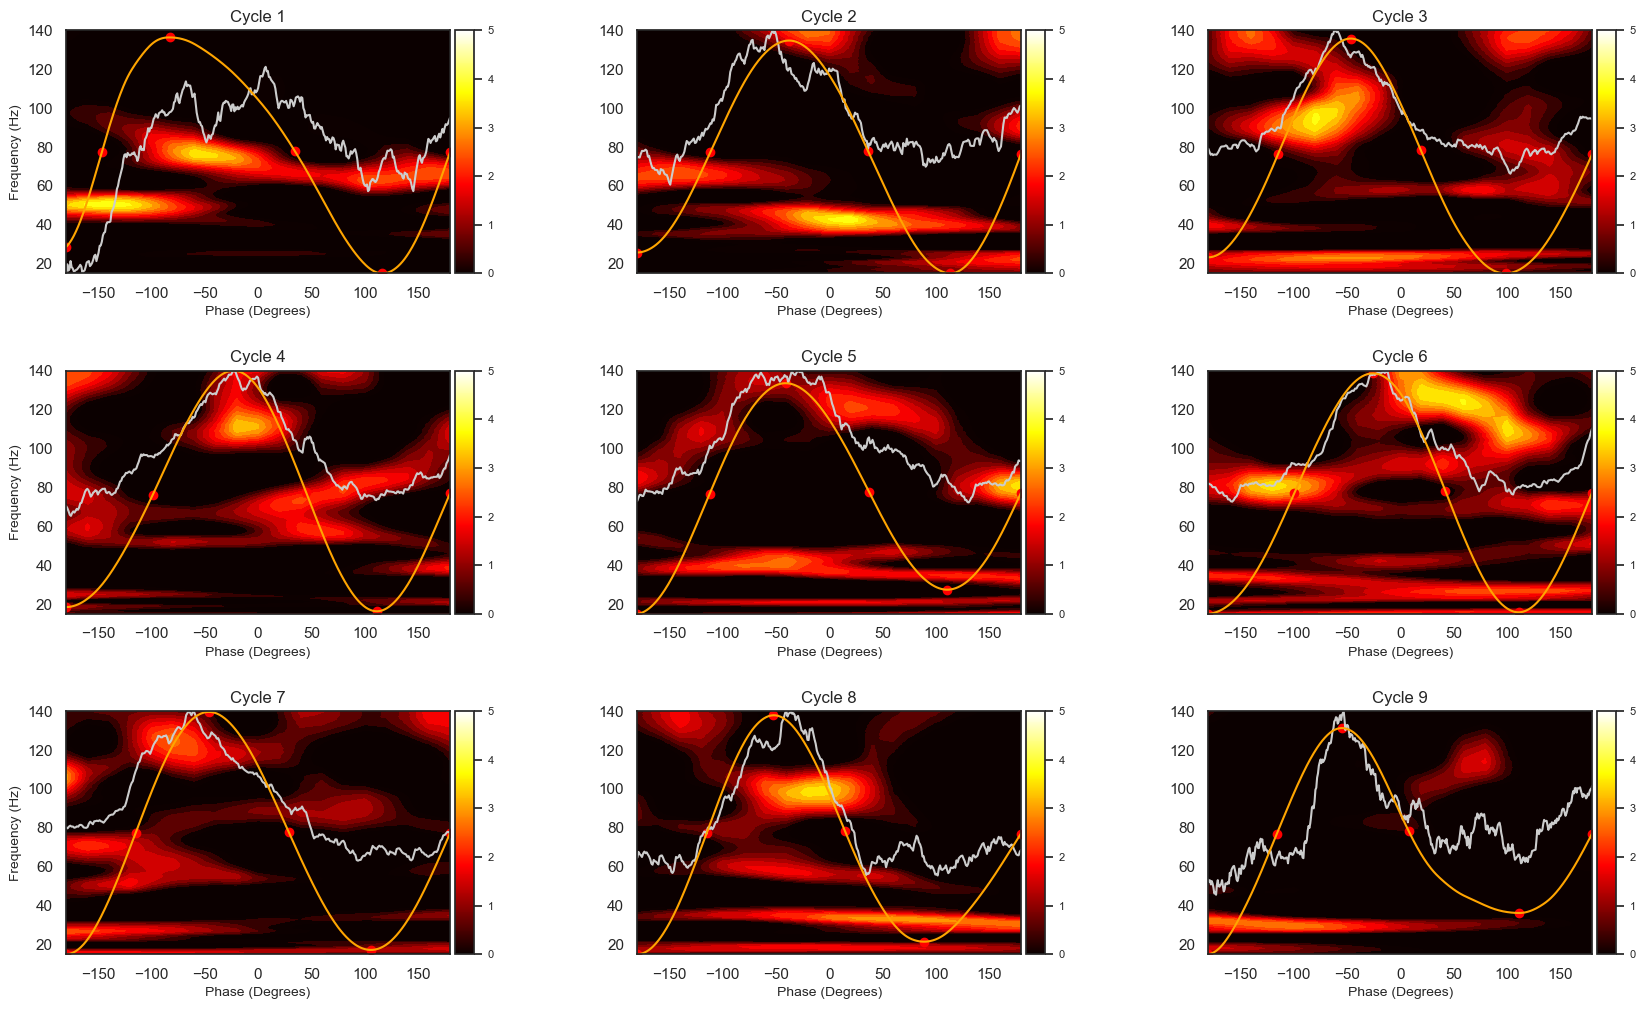

In [18]:
n_rows, n_cols = 3, 3
max_plots = n_rows * n_cols

vmin = 0
vmax = 5

n_levels = 20
levels = np.linspace(np.min(FPP), np.max(FPP), n_levels)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for ii in range(min(len(FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]

    # Create contourf plot with specified levels and normalization
    im = ax.contourf(angles, frequencies, FPP[ii], levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=10)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=10)

    ax.set_title(f"Cycle {ii+1}", fontsize=12)
    
    xinds = np.arange(len(all_cycles_inds[ii]))
    raw_lfp = firstRemLFP[all_cycles_inds[ii]]
    theta_part = imf[all_cycles_inds[ii], 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    # Plot raw LFP and IMF-6 on the current axis
    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP')
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6')

    # Plot control points
    ctrl_points_x = np.interp(all_cycles_ctrl[ii], np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[all_cycles_ctrl[ii]] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax, ticks=range(vmin, vmax+5, 5))
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=8)
plt.show()

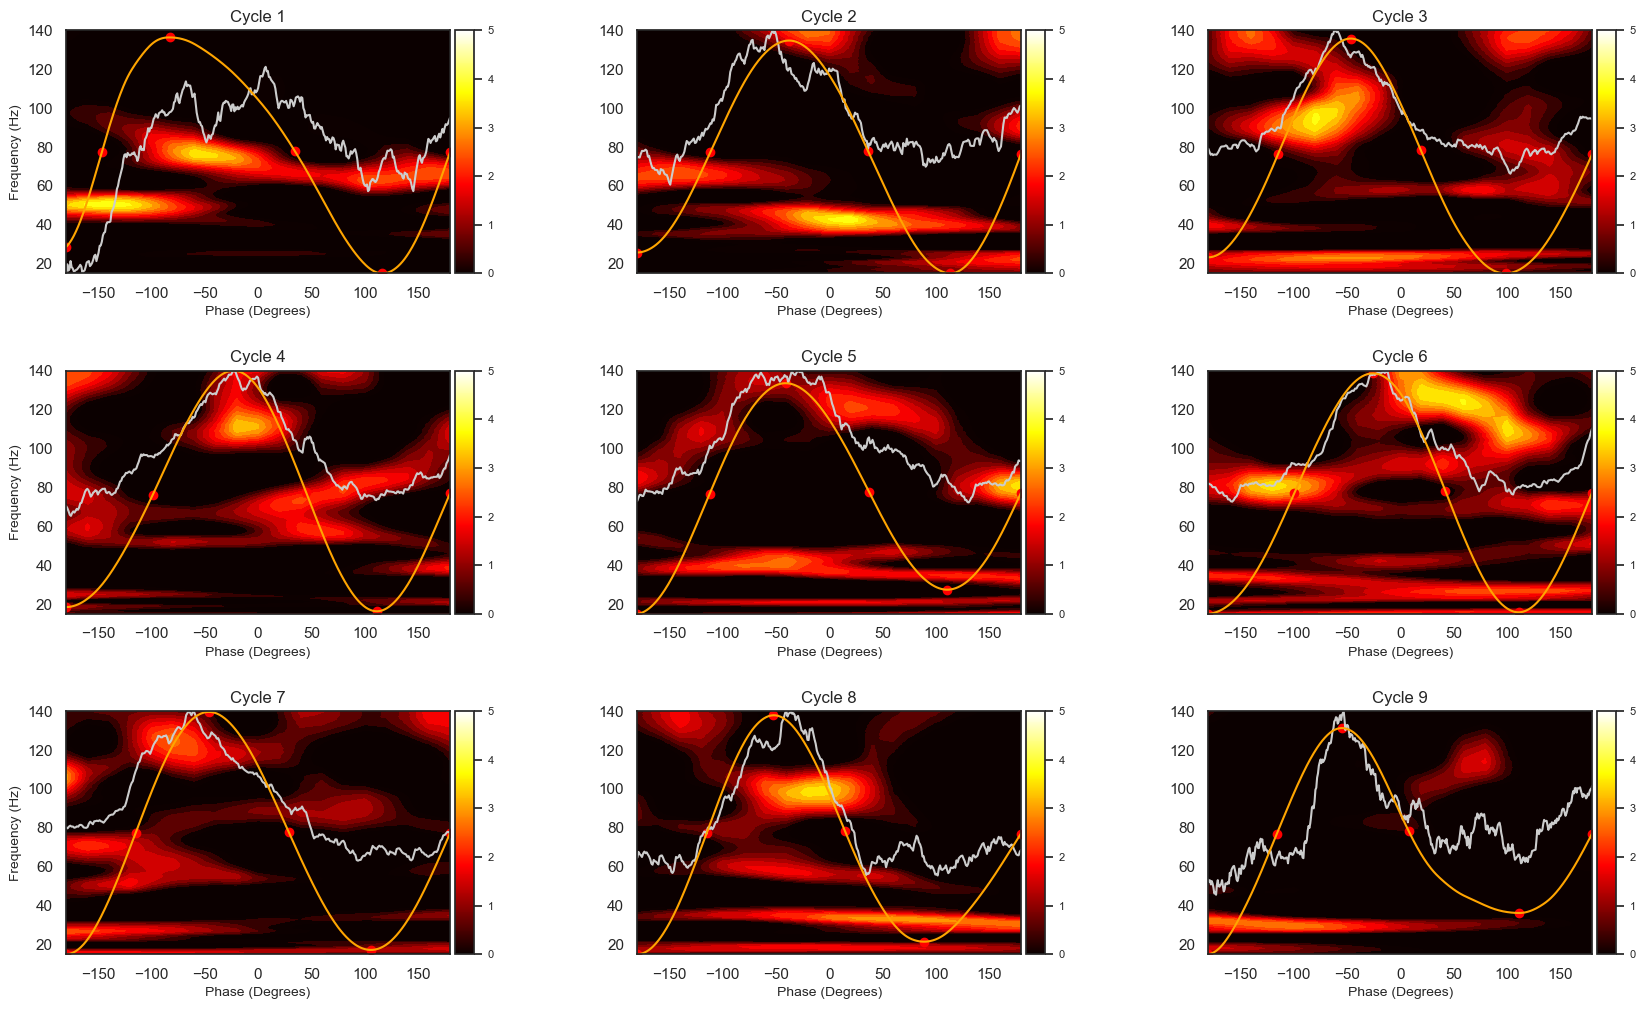

In [26]:
n_rows, n_cols = 3, 3
max_plots = n_rows * n_cols

vmin = 0
vmax = 5

n_levels = 20
levels = np.linspace(np.min(FPP), np.max(FPP), n_levels)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for ii in range(min(len(FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]

    # Create contourf plot with specified levels and normalization
    im = ax.contourf(angles, frequencies, FPP[ii], levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=10)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=10)

    ax.set_title(f"Cycle {ii+1}", fontsize=12)
    
    xinds = np.arange(len(all_cycles_inds[ii]))
    raw_lfp = firstRemLFP[all_cycles_inds[ii]]
    theta_part = imf[all_cycles_inds[ii], 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    # Plot raw LFP and IMF-6 on the current axis
    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP')
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6')

    # Plot control points
    ctrl_points_x = np.interp(all_cycles_ctrl[ii], np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[all_cycles_ctrl[ii]] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax, ticks=range(vmin, vmax+5, 5))
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=8)
plt.show()

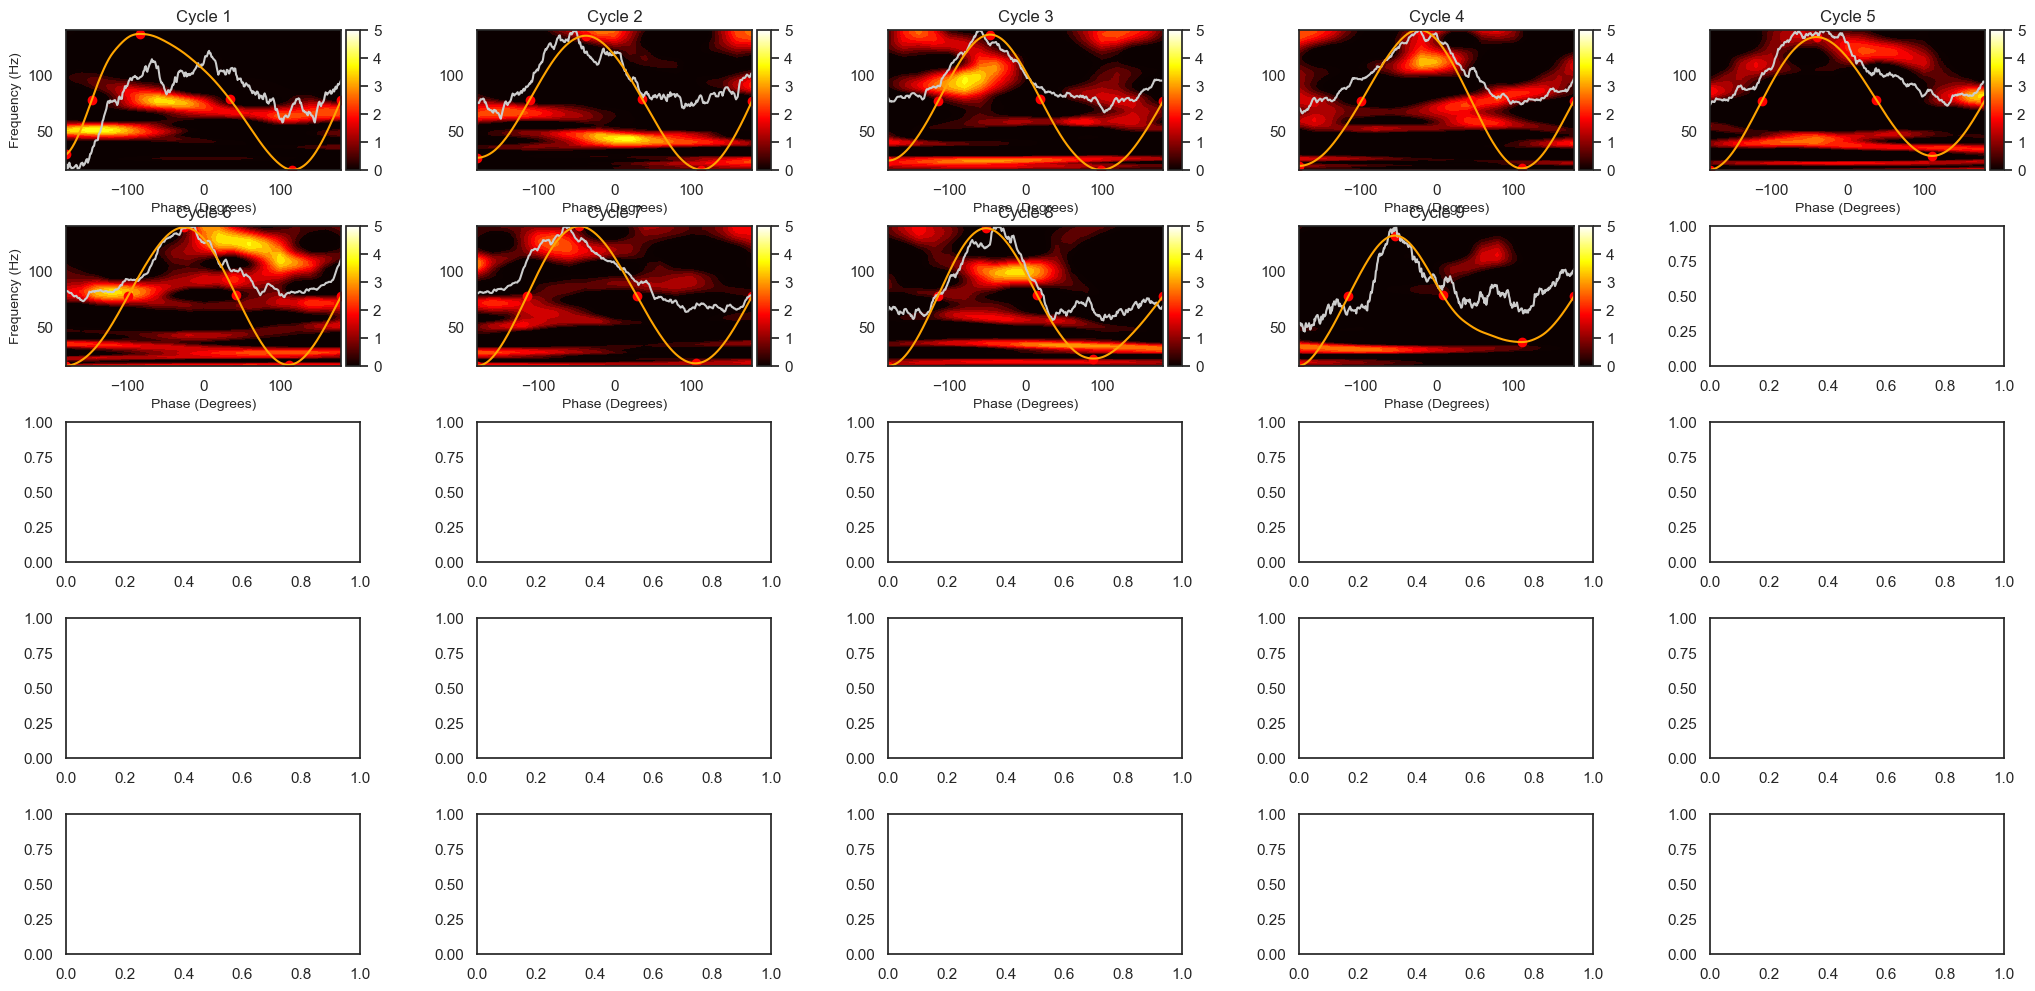

In [27]:
n_rows, n_cols = 5, 5  # 3 rows × 5 columns = 25 plots
max_plots = n_rows * n_cols  # 25 cycles

vmin = 0
vmax = 5

n_levels = 20
levels = np.linspace(np.min(FPP), np.max(FPP), n_levels)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 12))  # increase width for more columns
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for ii in range(min(len(FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]

    im = ax.contourf(angles, frequencies, FPP[ii], levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=10)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=10)

    ax.set_title(f"Cycle {ii+1}", fontsize=12)
    
    xinds = np.arange(len(all_cycles_inds[ii]))
    raw_lfp = firstRemLFP[all_cycles_inds[ii]]
    theta_part = imf[all_cycles_inds[ii], 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP')
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6')

    ctrl_points_x = np.interp(all_cycles_ctrl[ii], np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[all_cycles_ctrl[ii]] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax)
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))

plt.show()


In [28]:
print(f"Total cycles in FPP: {len(FPP)}")

Total cycles in FPP: 9


Total cycles available: 466


IndexError: index 4 is out of bounds for axis 0 with size 1

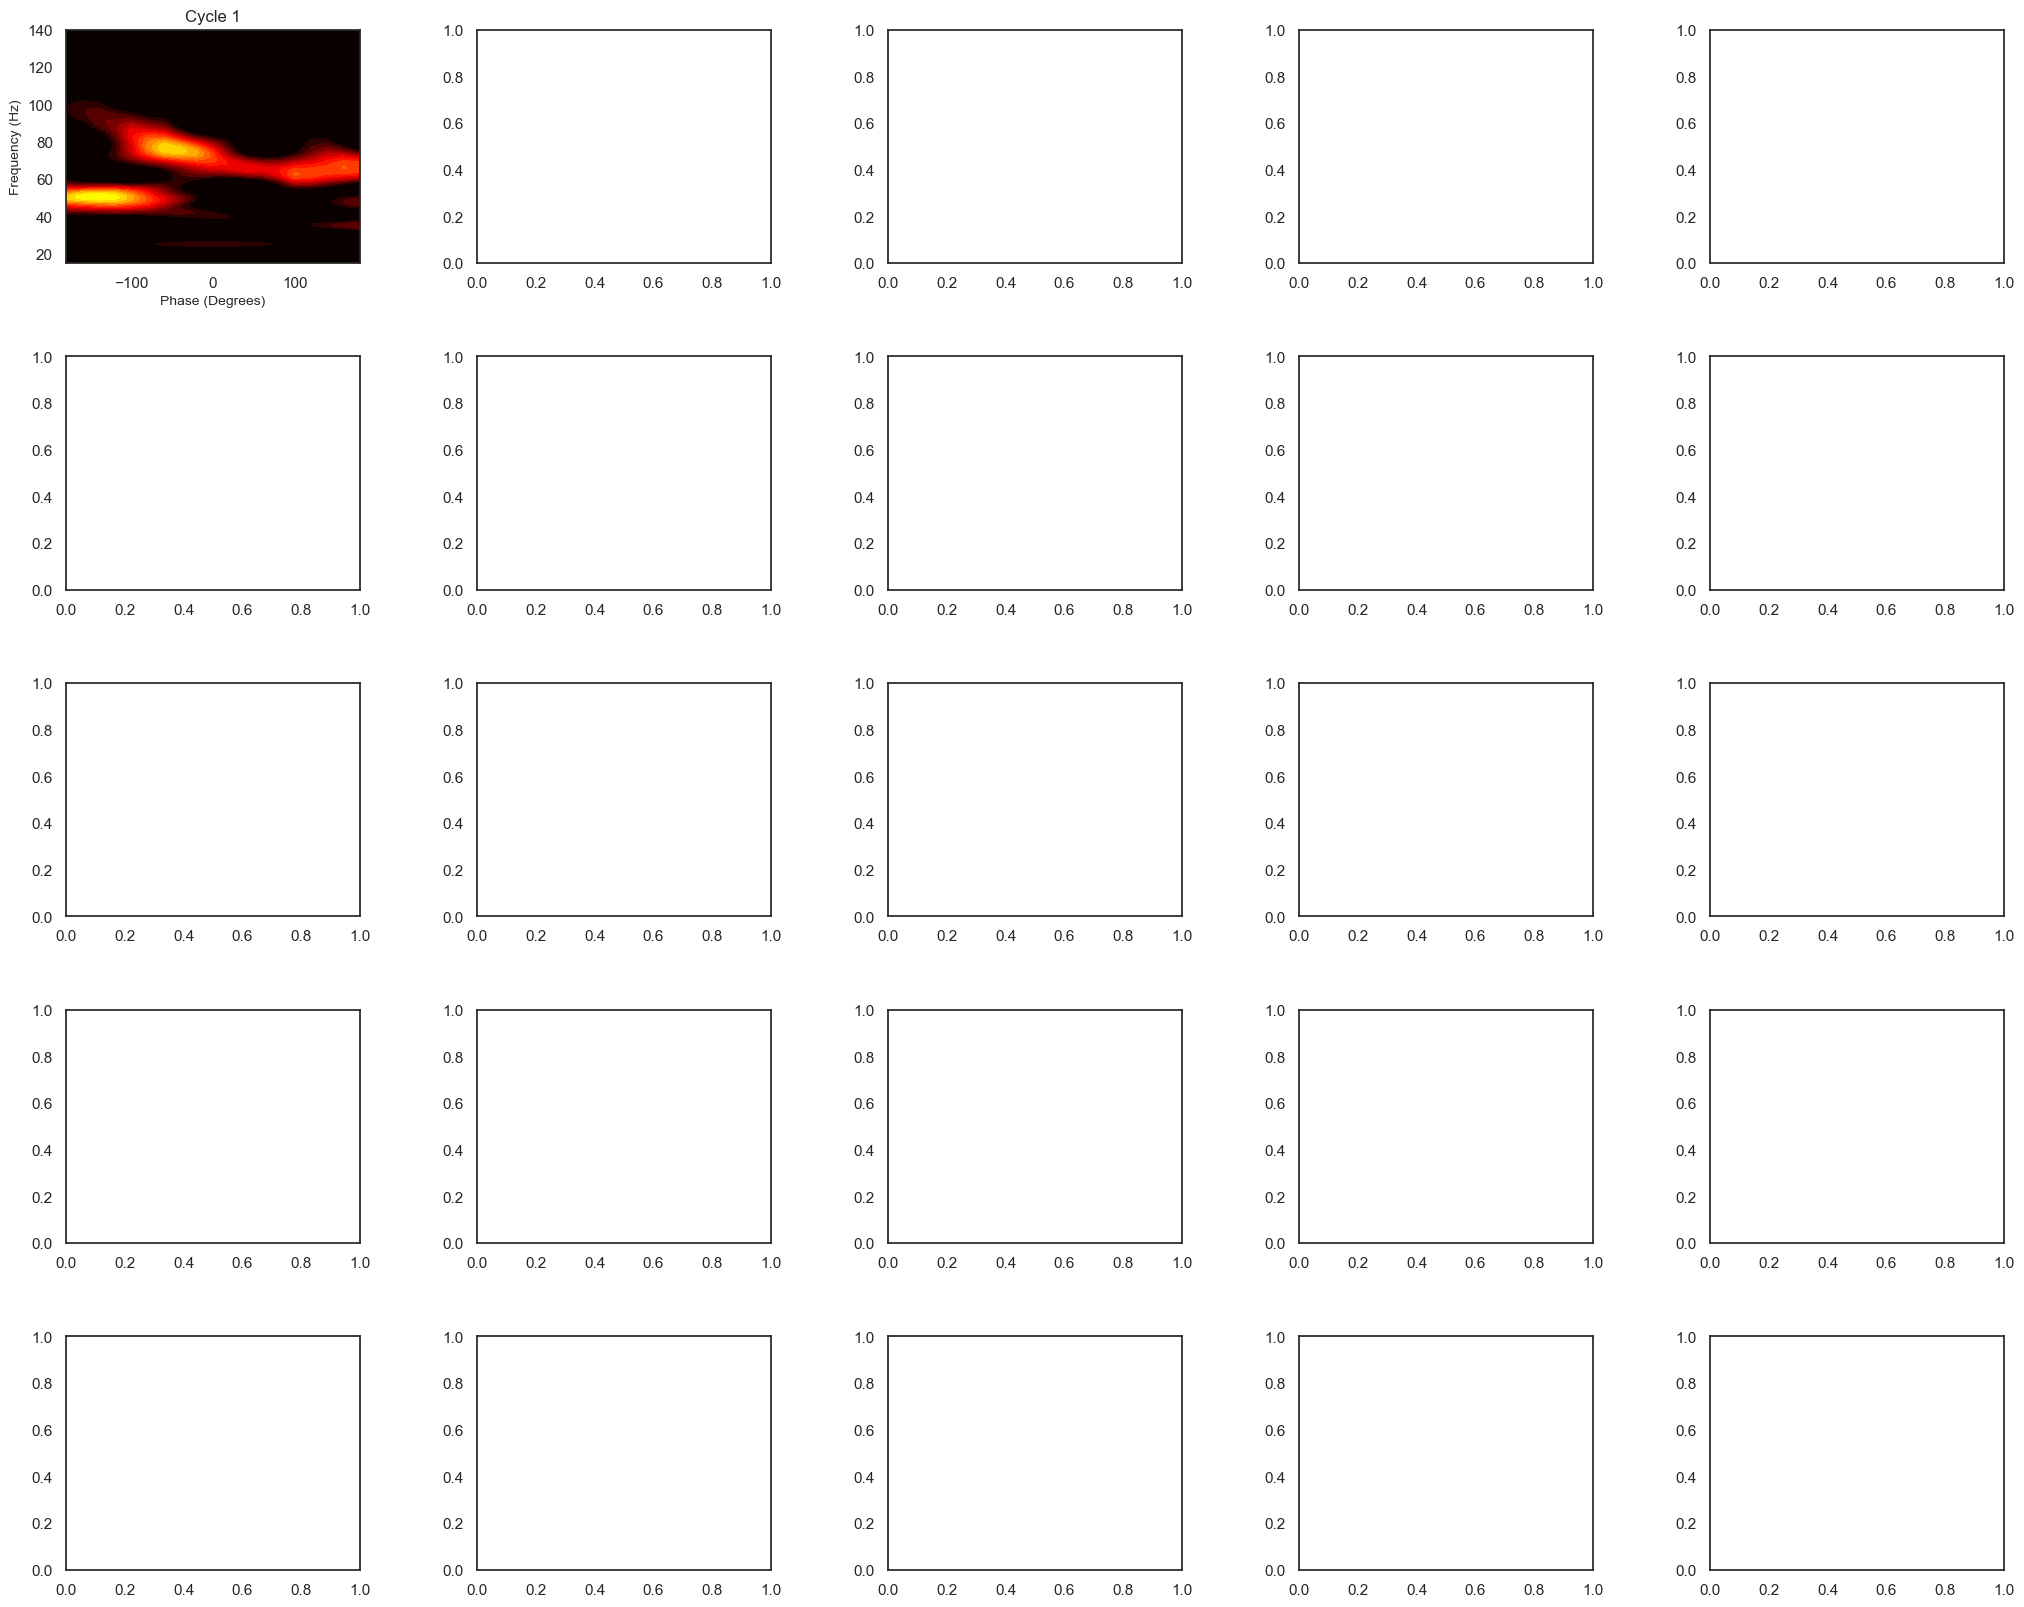

In [29]:
# Combine cycles from ALL phasic intervals
all_combined_FPP = []
all_combined_cycles_inds = []
all_combined_cycles_ctrl = []
all_combined_imfs = []
all_combined_rem_lfp = []

# Combine data from all intervals
for i in range(len(all_phasic_FPPs)):
    all_combined_FPP.extend(all_phasic_FPPs[i])
    all_combined_cycles_inds.extend(all_phasic_cycles_se[i])
    all_combined_cycles_ctrl.extend(all_phasic_cycle_ctrls[i])
    all_combined_imfs.extend(phasic_imfs[i])
    all_combined_rem_lfp.extend(rem_lpf[i])

print(f"Total cycles available: {len(all_combined_FPP)}")

# Now plot from the combined data
n_rows, n_cols = 5, 5
max_plots = n_rows * n_cols

vmin = 0
vmax = 5
n_levels = 20

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for ii in range(min(len(all_combined_FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]
    
    # Use the combined data
    FPP_cycle = all_combined_FPP[ii]
    cycles_inds = all_combined_cycles_inds[ii]
    cycles_ctrl = all_combined_cycles_ctrl[ii]
    imf_cycle = all_combined_imfs[ii]
    rem_lfp_cycle = all_combined_rem_lfp[ii]
    
    levels = np.linspace(np.min(FPP_cycle), np.max(FPP_cycle), n_levels)
    im = ax.contourf(angles, frequencies, FPP_cycle, levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=10)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=10)
    ax.set_title(f"Cycle {ii+1}", fontsize=12)
    
    xinds = np.arange(len(cycles_inds))
    raw_lfp = rem_lfp_cycle[cycles_inds]
    theta_part = imf_cycle[cycles_inds, 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP')
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6')

    ctrl_points_x = np.interp(cycles_ctrl, np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[cycles_ctrl] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax)
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=8)

plt.show()

Total cycles available: 466


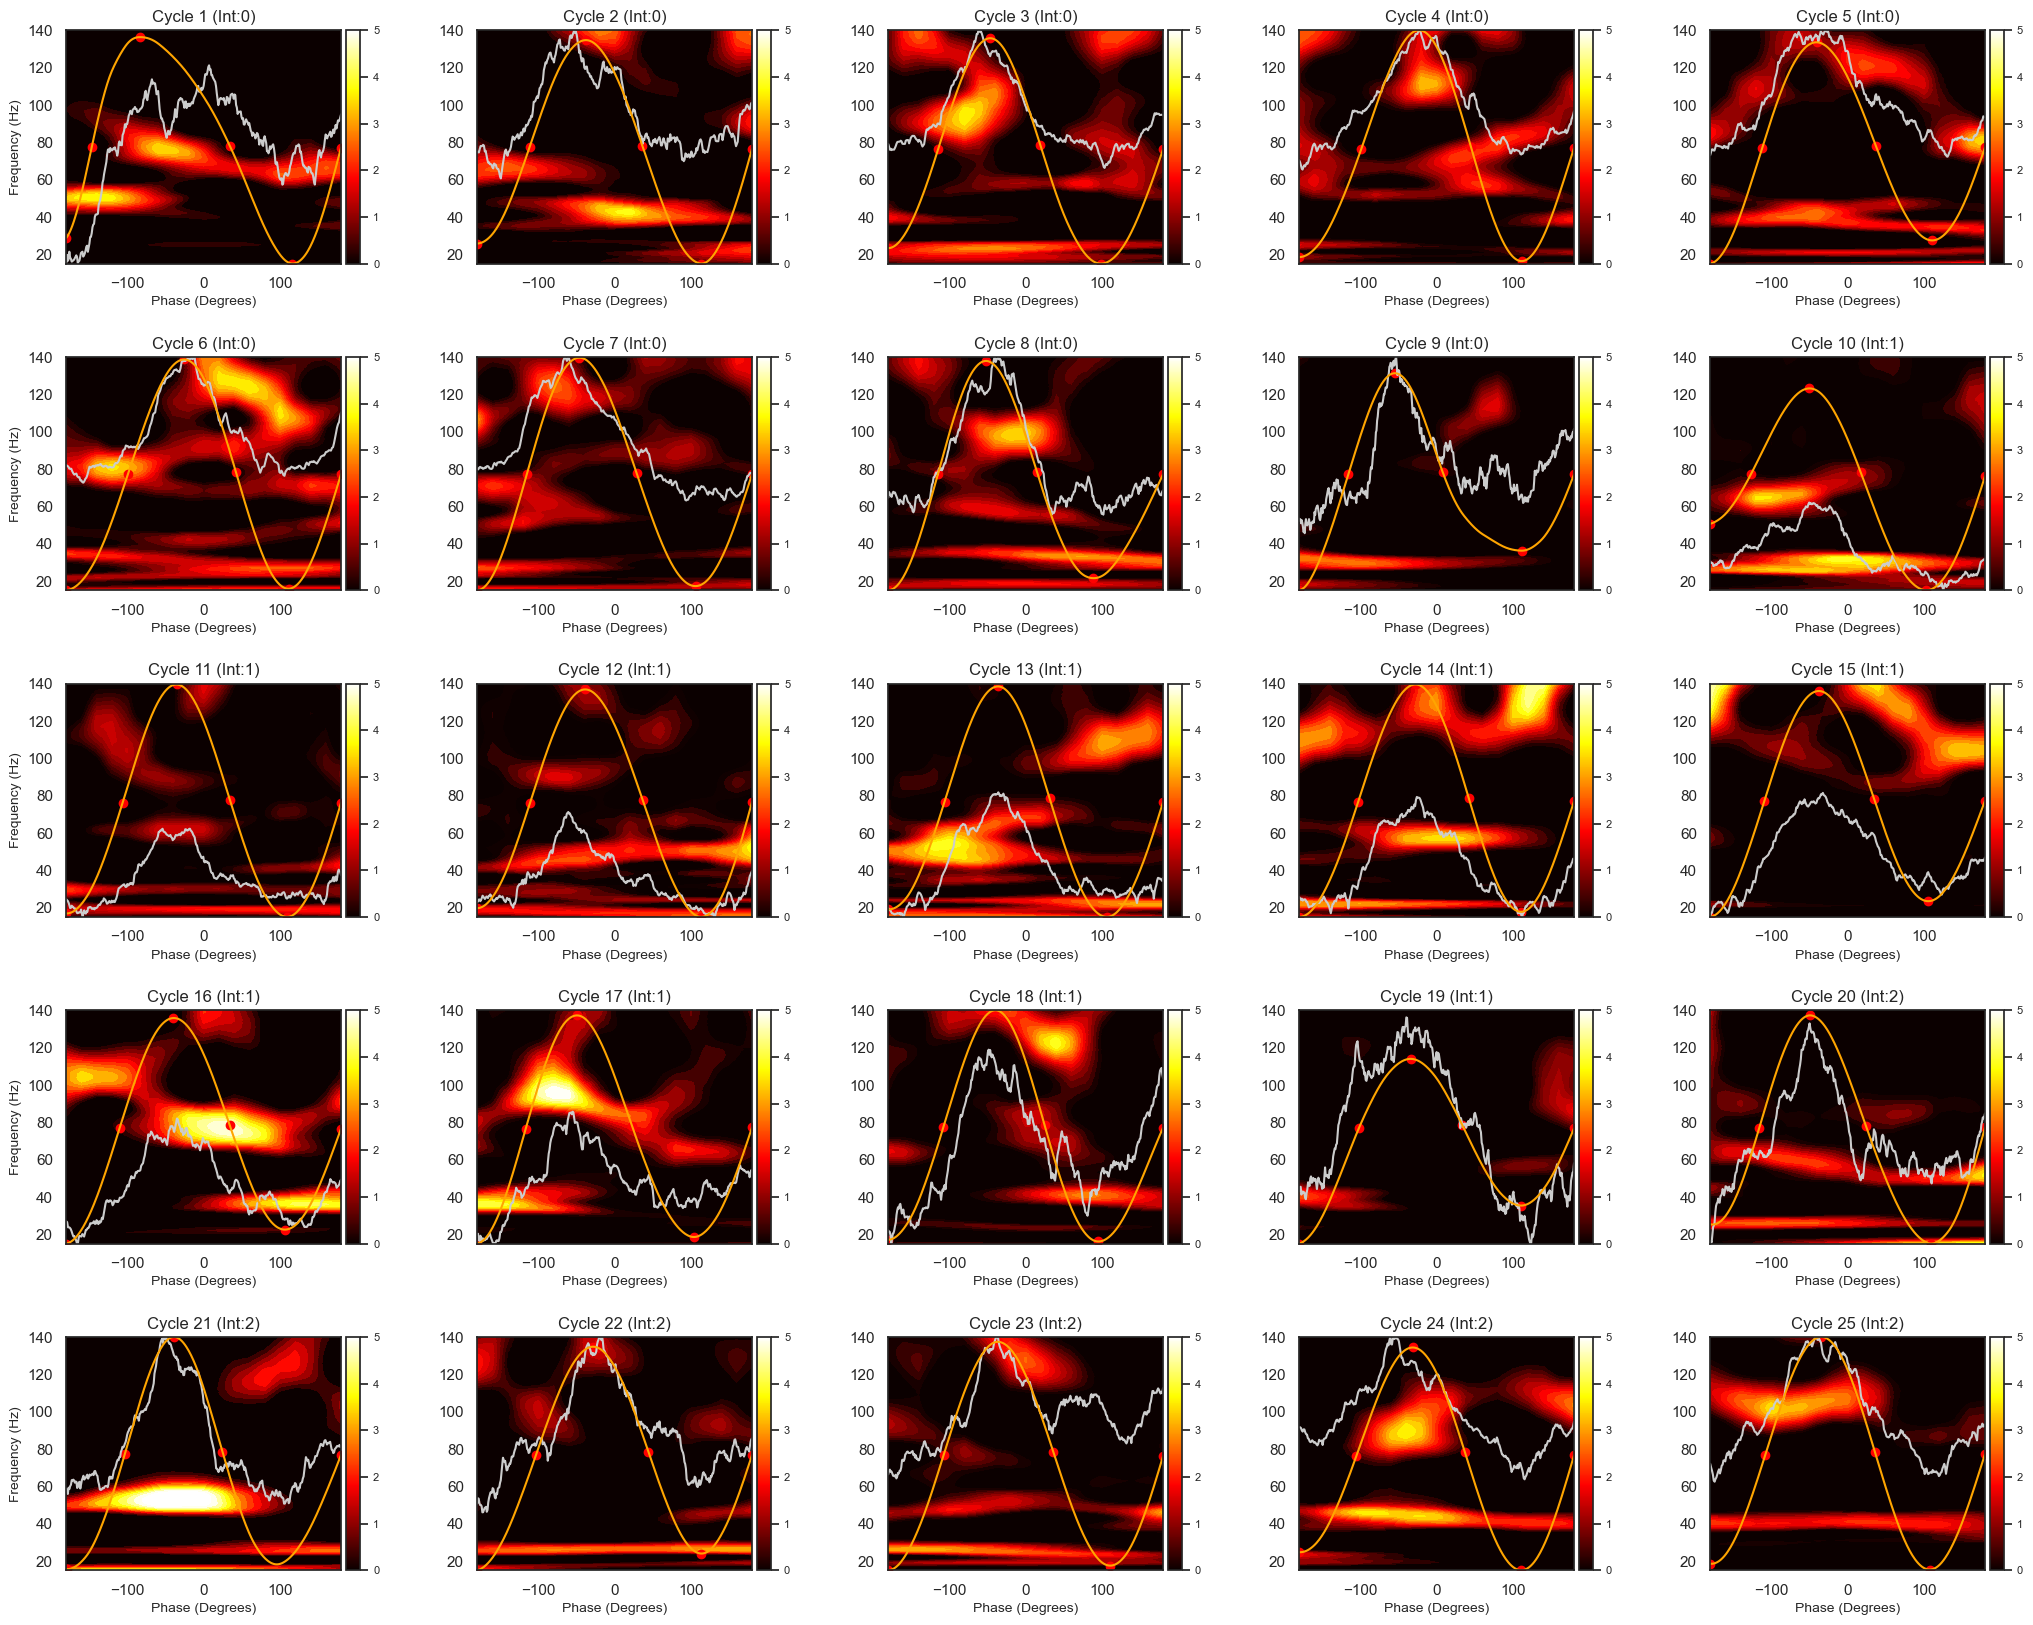

In [30]:
# Combine cycles from ALL phasic intervals
all_combined_FPP = []
all_combined_cycles_inds = []
all_combined_cycles_ctrl = []
all_combined_imfs = []  # This will store the FULL IMF arrays for each interval
all_combined_rem_lfp = []  # This will store the FULL LFP arrays for each interval
all_cycle_to_interval_map = []  # Map which cycle belongs to which interval

# Combine data from all intervals
for interval_idx in range(len(all_phasic_FPPs)):
    for cycle_idx in range(len(all_phasic_FPPs[interval_idx])):
        all_combined_FPP.append(all_phasic_FPPs[interval_idx][cycle_idx])
        all_combined_cycles_inds.append(all_phasic_cycles_se[interval_idx][cycle_idx])
        all_combined_cycles_ctrl.append(all_phasic_cycle_ctrls[interval_idx][cycle_idx])
        # Store reference to the parent IMF and LFP arrays
        all_combined_imfs.append(phasic_imfs[interval_idx])
        all_combined_rem_lfp.append(rem_lpf[interval_idx])
        all_cycle_to_interval_map.append(interval_idx)

print(f"Total cycles available: {len(all_combined_FPP)}")

# Now plot from the combined data
n_rows, n_cols = 5, 5
max_plots = n_rows * n_cols

vmin = 0
vmax = 5
n_levels = 20

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for ii in range(min(len(all_combined_FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]
    
    # Use the combined data
    FPP_cycle = all_combined_FPP[ii]
    cycles_inds = all_combined_cycles_inds[ii]
    cycles_ctrl = all_combined_cycles_ctrl[ii]
    imf_full = all_combined_imfs[ii]  # Full IMF array for this interval
    rem_lfp_full = all_combined_rem_lfp[ii]  # Full LFP array for this interval
    
    levels = np.linspace(np.min(FPP_cycle), np.max(FPP_cycle), n_levels)
    im = ax.contourf(angles, frequencies, FPP_cycle, levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=10)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=10)
    ax.set_title(f"Cycle {ii+1} (Int:{all_cycle_to_interval_map[ii]})", fontsize=12)
    
    xinds = np.arange(len(cycles_inds))
    raw_lfp = rem_lfp_full[cycles_inds]  # Index into the full LFP array
    theta_part = imf_full[cycles_inds, 5]  # Index into the full IMF array

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP')
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6')

    ctrl_points_x = np.interp(cycles_ctrl, np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[cycles_ctrl] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax)
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=8)

plt.show()

Total cycles available: 466


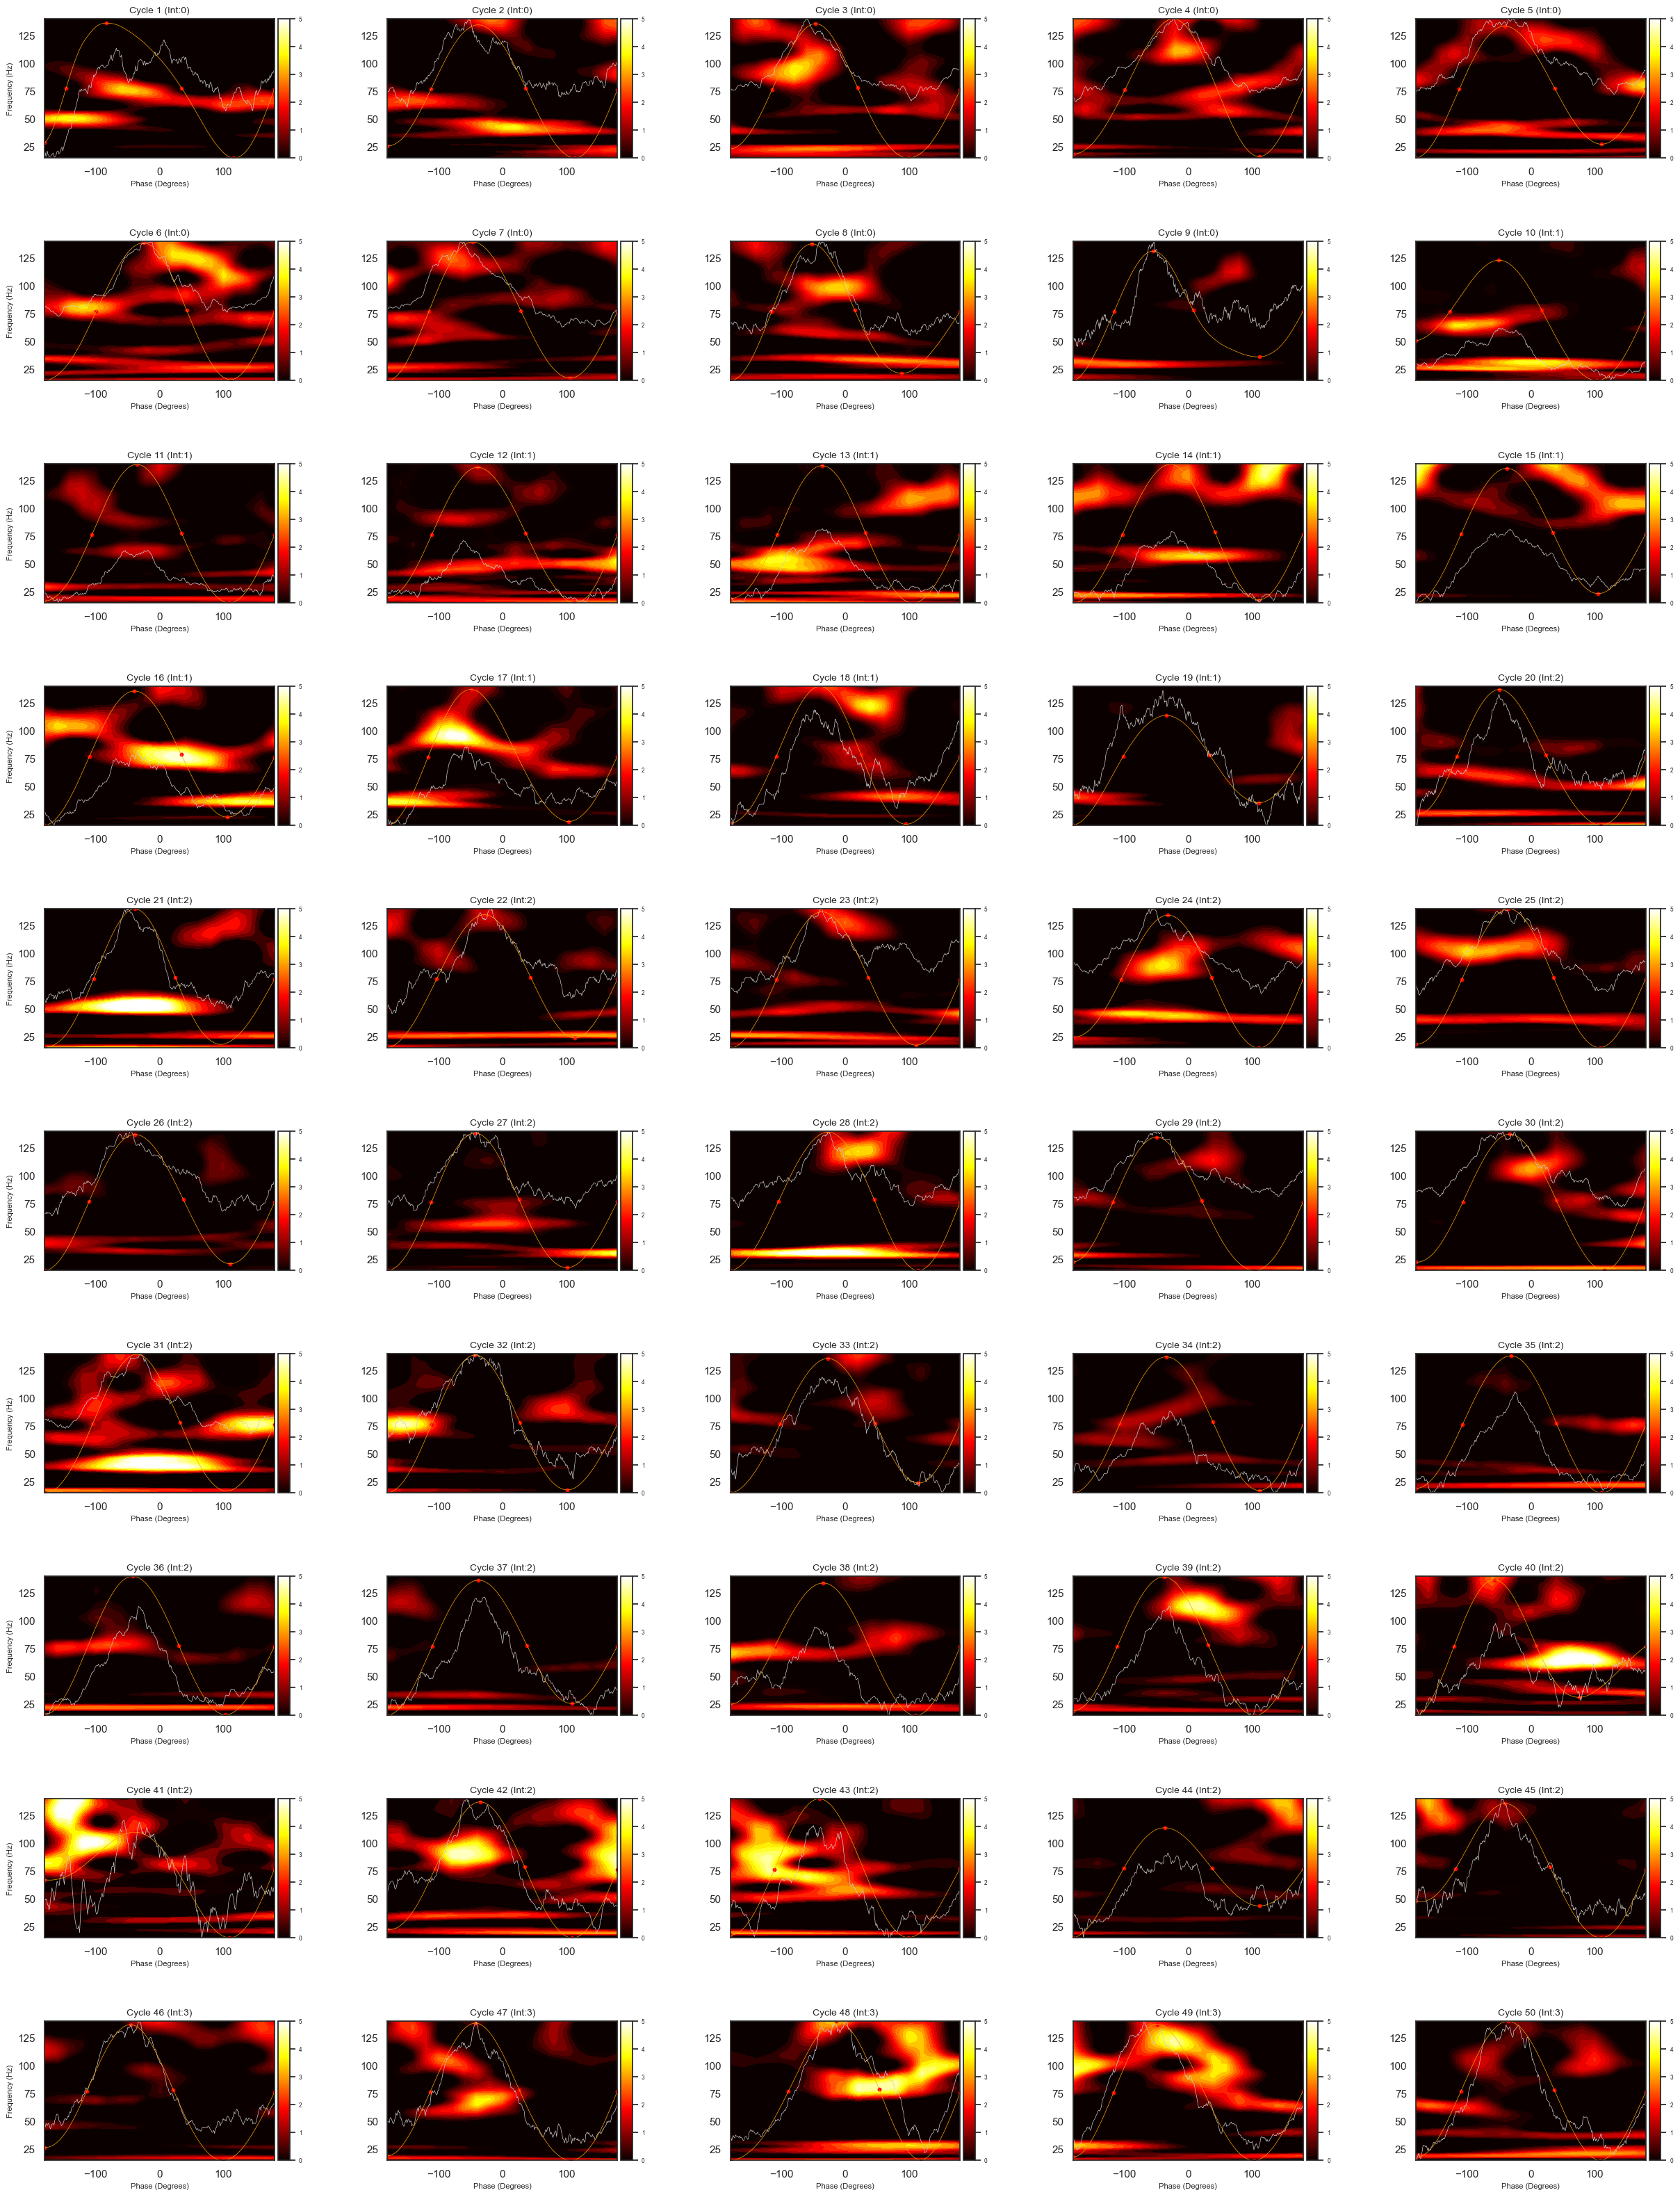

In [31]:
# Combine cycles from ALL <<<<<PHASIC>>>>> intervals
all_combined_FPP = []
all_combined_cycles_inds = []
all_combined_cycles_ctrl = []
all_combined_imfs = []
all_combined_rem_lfp = []
all_cycle_to_interval_map = []

# Combine data from all intervals
for interval_idx in range(len(all_phasic_FPPs)):
    for cycle_idx in range(len(all_phasic_FPPs[interval_idx])):
        all_combined_FPP.append(all_phasic_FPPs[interval_idx][cycle_idx])
        all_combined_cycles_inds.append(all_phasic_cycles_se[interval_idx][cycle_idx])
        all_combined_cycles_ctrl.append(all_phasic_cycle_ctrls[interval_idx][cycle_idx])
        all_combined_imfs.append(phasic_imfs[interval_idx])
        all_combined_rem_lfp.append(rem_lpf[interval_idx])
        all_cycle_to_interval_map.append(interval_idx)

print(f"Total cycles available: {len(all_combined_FPP)}")

# Set up for 50 cycles (10 rows x 5 columns)
n_rows, n_cols = 10, 5
max_plots = n_rows * n_cols

vmin = 0
vmax = 5
n_levels = 20

# Create a larger figure for 50 cycles
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 40))
plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Increased vertical spacing

# Flatten axes for easier indexing if needed
axes_flat = axes.flatten()

for ii in range(min(len(all_combined_FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]
    
    # Use the combined data
    FPP_cycle = all_combined_FPP[ii]
    cycles_inds = all_combined_cycles_inds[ii]
    cycles_ctrl = all_combined_cycles_ctrl[ii]
    imf_full = all_combined_imfs[ii]
    rem_lfp_full = all_combined_rem_lfp[ii]
    
    levels = np.linspace(np.min(FPP_cycle), np.max(FPP_cycle), n_levels)
    im = ax.contourf(angles, frequencies, FPP_cycle, levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=8)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=8)
    ax.set_title(f"Cycle {ii+1} (Int:{all_cycle_to_interval_map[ii]})", fontsize=10)
    
    xinds = np.arange(len(cycles_inds))
    raw_lfp = rem_lfp_full[cycles_inds]
    theta_part = imf_full[cycles_inds, 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP', linewidth=0.5)
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6', linewidth=0.5)

    ctrl_points_x = np.interp(cycles_ctrl, np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[cycles_ctrl] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', s=10, label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax)
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=6)

# Remove empty subplots if we have fewer than 50 cycles
if len(all_combined_FPP) < max_plots:
    for jj in range(len(all_combined_FPP), max_plots):
        fig.delaxes(axes_flat[jj])

plt.show()

Total TONIC cycles available: 9403


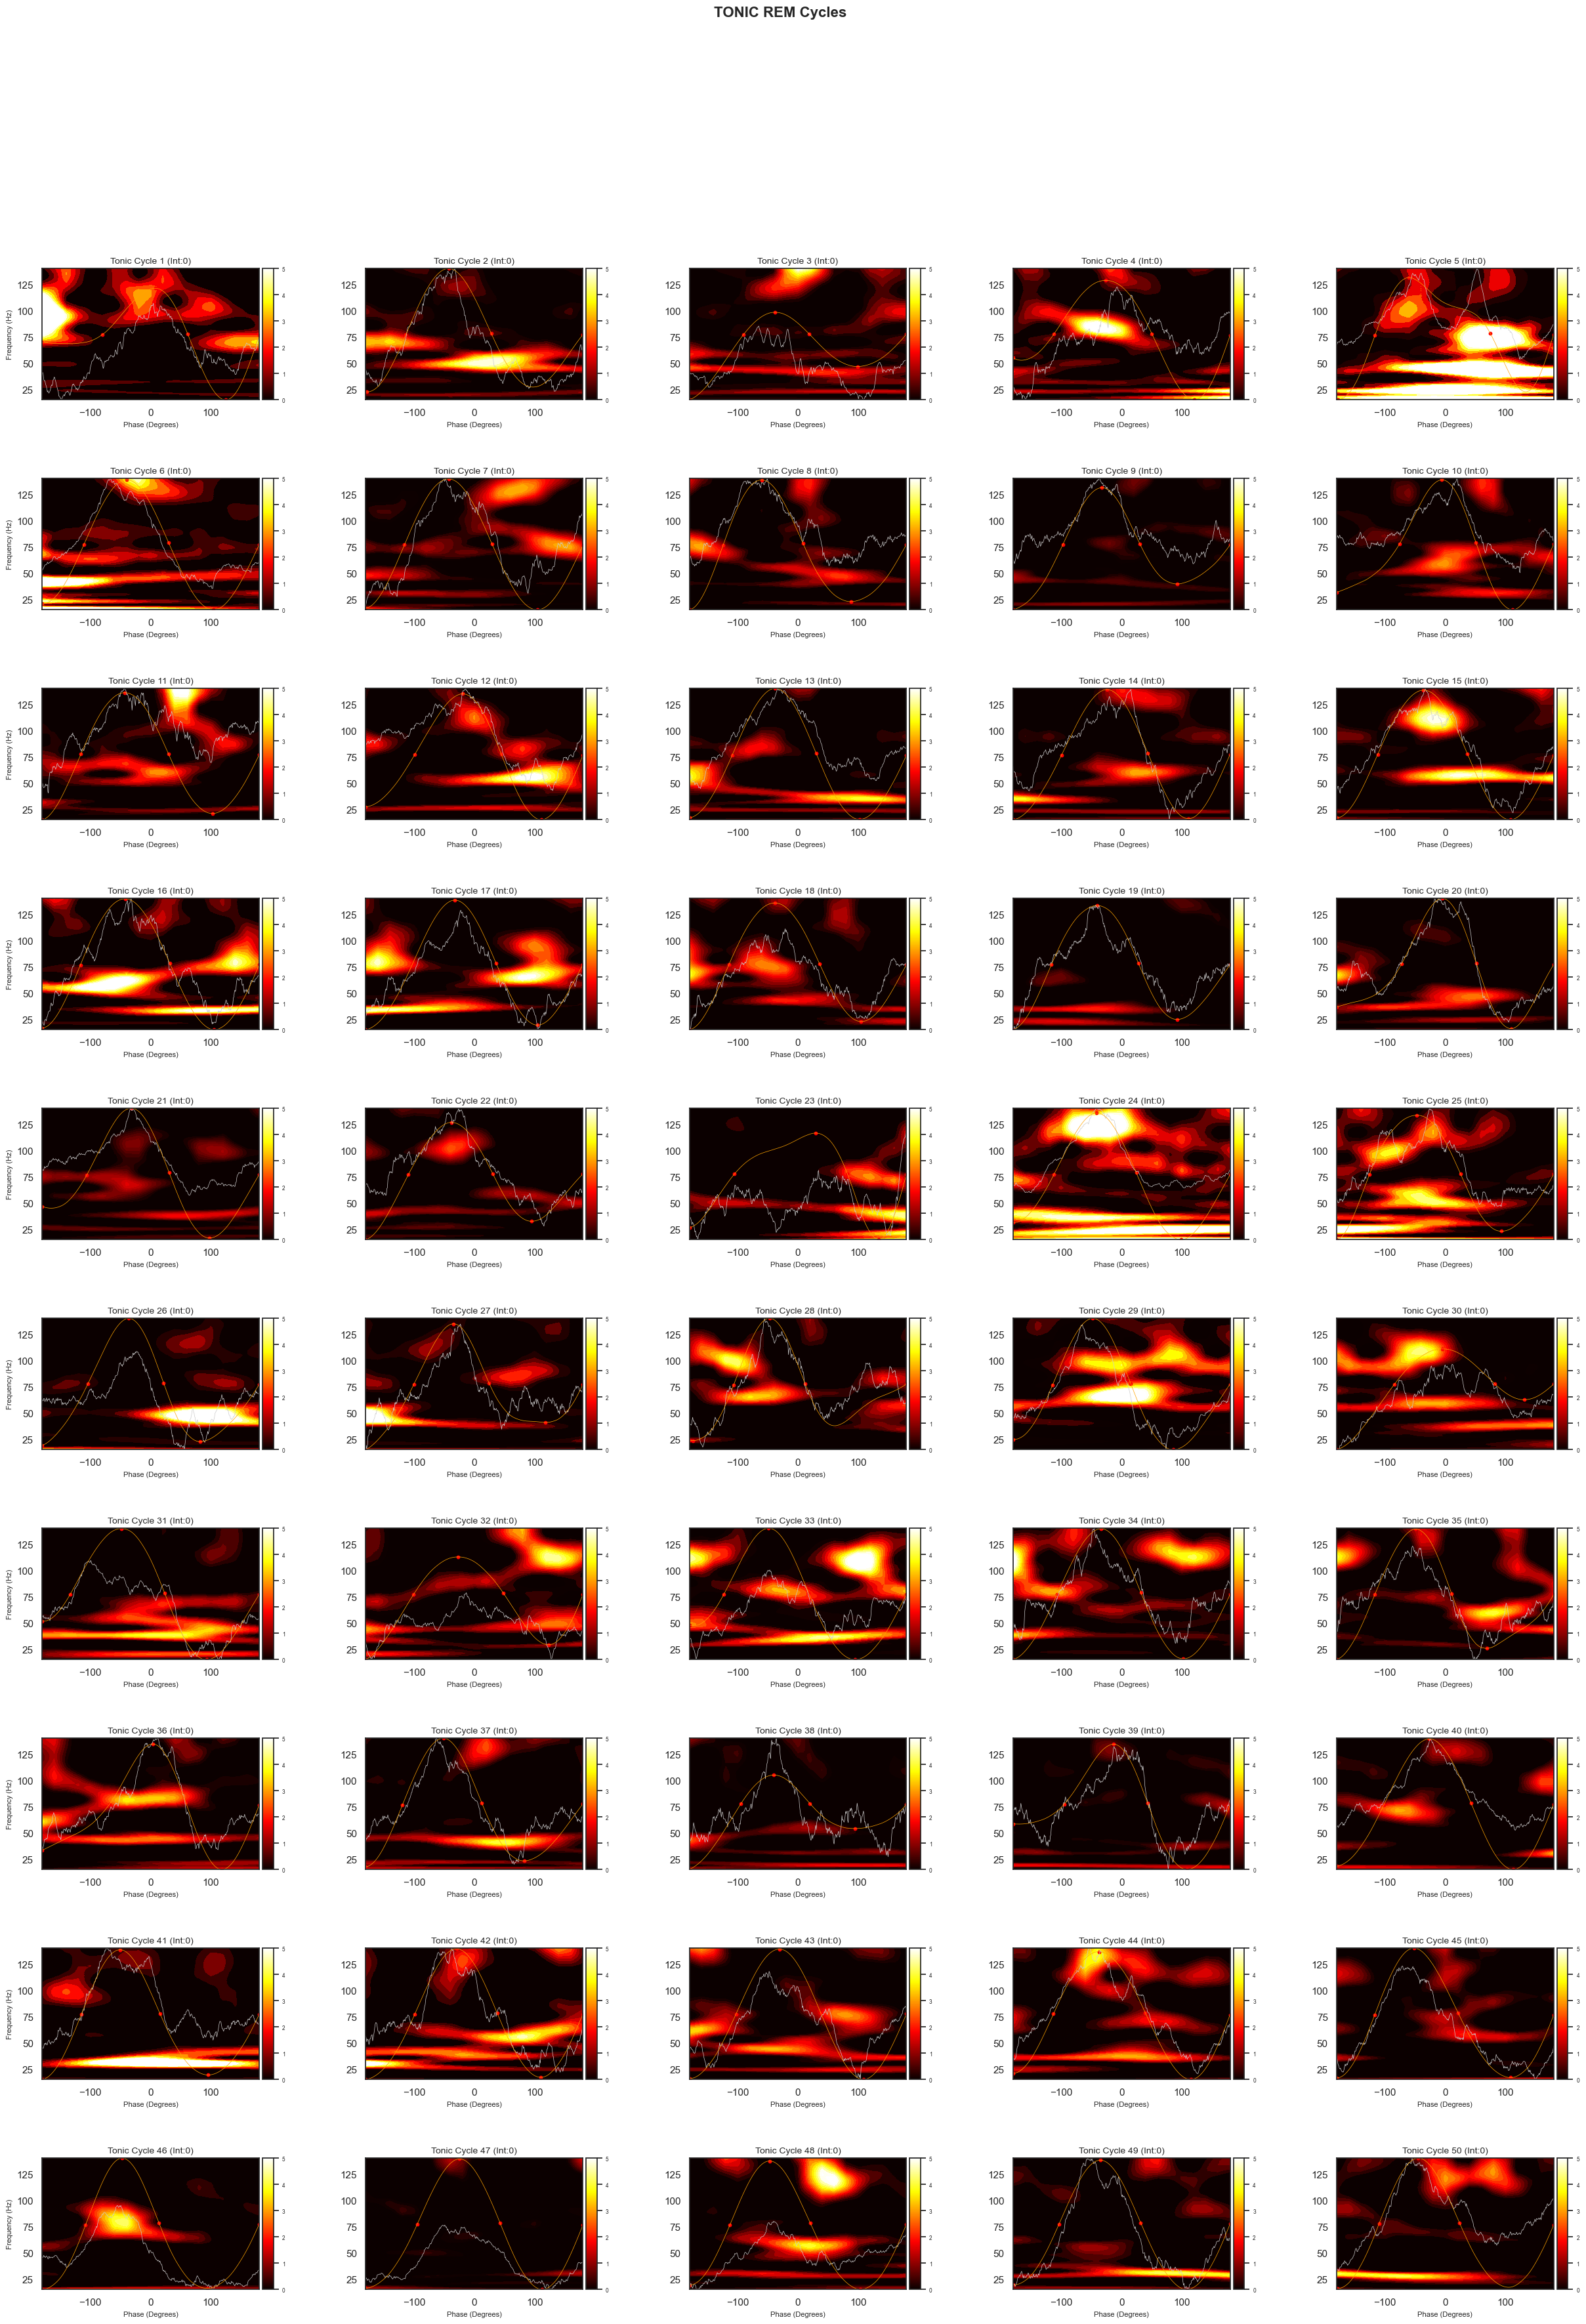

In [32]:
# Combine cycles from ALL <<<<<<<<TONIC>>>>>>>>> intervals
all_combined_FPP = []
all_combined_cycles_inds = []
all_combined_cycles_ctrl = []
all_combined_imfs = []
all_combined_rem_lfp = []
all_cycle_to_interval_map = []

# Combine data from all TONIC intervals (changed from phasic to tonic)
for interval_idx in range(len(all_tonic_FPPs)):
    for cycle_idx in range(len(all_tonic_FPPs[interval_idx])):
        all_combined_FPP.append(all_tonic_FPPs[interval_idx][cycle_idx])
        all_combined_cycles_inds.append(all_tonic_cycles_se[interval_idx][cycle_idx])
        all_combined_cycles_ctrl.append(all_tonic_cycle_ctrls[interval_idx][cycle_idx])
        all_combined_imfs.append(tonic_imfs[interval_idx])  # Changed to tonic_imfs
        all_combined_rem_lfp.append(tonic_rem_lpf[interval_idx])  # Changed to tonic_rem_lpf
        all_cycle_to_interval_map.append(interval_idx)

print(f"Total TONIC cycles available: {len(all_combined_FPP)}")

# Set up for 50 cycles (10 rows x 5 columns)
n_rows, n_cols = 10, 5
max_plots = n_rows * n_cols

vmin = 0
vmax = 5
n_levels = 20

# Create a larger figure for 50 cycles
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 40))
plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Increased vertical spacing

# Flatten axes for easier indexing if needed
axes_flat = axes.flatten()

for ii in range(min(len(all_combined_FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]
    
    # Use the combined data
    FPP_cycle = all_combined_FPP[ii]
    cycles_inds = all_combined_cycles_inds[ii]
    cycles_ctrl = all_combined_cycles_ctrl[ii]
    imf_full = all_combined_imfs[ii]
    rem_lfp_full = all_combined_rem_lfp[ii]
    
    levels = np.linspace(np.min(FPP_cycle), np.max(FPP_cycle), n_levels)
    im = ax.contourf(angles, frequencies, FPP_cycle, levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=8)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=8)
    ax.set_title(f"Tonic Cycle {ii+1} (Int:{all_cycle_to_interval_map[ii]})", fontsize=10)  # Changed title
    
    xinds = np.arange(len(cycles_inds))
    raw_lfp = rem_lfp_full[cycles_inds]
    theta_part = imf_full[cycles_inds, 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP', linewidth=0.5)
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6', linewidth=0.5)

    ctrl_points_x = np.interp(cycles_ctrl, np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[cycles_ctrl] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', s=10, label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax)
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=6)

# Remove empty subplots if we have fewer than 50 cycles
if len(all_combined_FPP) < max_plots:
    for jj in range(len(all_combined_FPP), max_plots):
        fig.delaxes(axes_flat[jj])

plt.suptitle("TONIC REM Cycles", fontsize=16, fontweight='bold')  # Added main title
plt.show()

In [ ]:
##### NOW LETS DO ALL THIS JOBS WITH <PFC> INSTEAD OF HPC!

In [3]:
path_to_pfc = "C:/Users/pc/Data_pipeline_project/mani-data-example/mani-data-example/2018-11-05_14-15-28_Post_Trial5/PFC_100_CH45_0.continuous.mat"
path_to_states = "C:/Users/pc/Data_pipeline_project/mani-data-example/mani-data-example/2018-11-05_14-15-28_Post_Trial5/2018-11-05_14-15-28_post_trial5-states.mat"

In [6]:
config = emd.sift.SiftConfig.from_yaml_file(
    r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\emd_masksift_CA1_config_2500.yml"
)

In [7]:
lfpPFC, hypno, fs = get_data_p(path_to_pfc, path_to_states)

There was 0 in the dataset


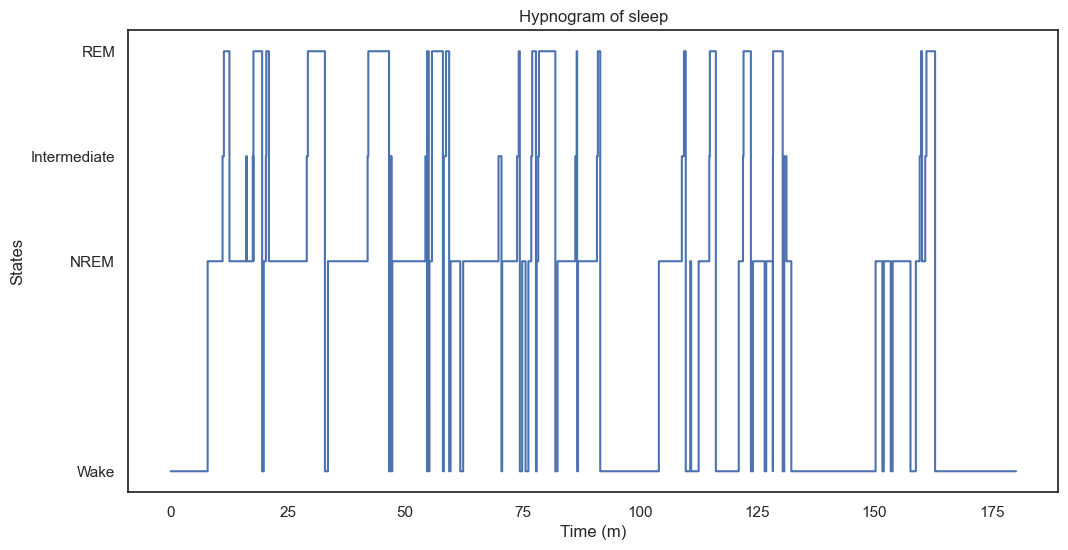

In [8]:
plot_hypnogram(hypno)

In [9]:
def extract_pt_intervals(lfpPFC, hypno, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpPFC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpPFC, columns=['PFC'])

    # Detect phasic intervals
    lfpPFC_down = preprocess(lfpPFC, n_down)
    phREM = detect_phasic(lfpPFC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [10]:
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpPFC, hypno)

Number of detected Tonic intrevals:29
Number of detected Tonic intrevals after threshold:29


In [11]:
len(phasic_interval)

10

In [12]:
def get_cycle_data(imf5, fs=2500):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [13]:
def extract_imfs_by_pt_intervals(lfp, fs, interval, config, return_imfs_freqs=False):

    all_imfs = []
    all_imf_freqs = []
    rem_lfp = []
    all_masked_freqs = []
    for ii in range(len(interval)):
        start_idx = int(interval.loc[ii, 'start'] * fs)
        end_idx = int(interval.loc[ii, 'end'] * fs)
        sig_part = lfp[start_idx:end_idx]
        sig = np.array(sig_part)

        rem_lfp.append(sig)

        try:
            imf, mask_freq = sift.mask_sift(sig, **config)
        except Exception as e:
            print(f"EMD Sift failed: {e}. Skipping this interval.")
            continue
        all_imfs.append(imf)
        all_masked_freqs.append(mask_freq)

        imf_frequencies = imf_freq(imf, fs)
        all_imf_freqs.append(imf_frequencies)

    if return_imfs_freqs:
        return all_imfs, all_imf_freqs, rem_lfp
    else:
        return all_imfs

In [14]:
tonic_imfs, tonic_imfs_freqs, tonic_rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, tonic_interval, config, return_imfs_freqs=True)

In [15]:
phasic_imfs, phasic_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, phasic_interval, config, return_imfs_freqs=True)

In [16]:
def extract_cycle_info(imfs, imf_frequencies):

  all_FPPs = []
  all_cycles_se =[]
  all_cycles_ctrl = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']

    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    ctrl = emd.cycles.get_control_points(imf[:, 5], cycle_data['cycles'], mode='augmented')
    cycle_ctrls = get_cycle_ctrl(ctrl, subset_indices)
    all_cycles_ctrl.append(cycle_ctrls)
    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    all_cycles_se.append(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

  return all_cycles_ctrl, all_cycles_se, all_FPPs

In [17]:
all_phasic_cycle_ctrls, all_phasic_cycles_se, all_phasic_FPPs = extract_cycle_info(phasic_imfs, phasic_imfs_freqs)
all_tonic_cycle_ctrls, all_tonic_cycles_se, all_tonic_FPPs = extract_cycle_info(tonic_imfs, tonic_imfs_freqs)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs 

In [18]:
frequencies = np.arange(15, 141, 1)
angles = np.linspace(-180, 180, 19)

In [19]:
# Check if you have PFC data
print(f"PFC phasic intervals: {len(all_phasic_FPPs)}")
print(f"PFC tonic intervals: {len(all_tonic_FPPs)}")

PFC phasic intervals: 10
PFC tonic intervals: 29


Total PFC TONIC cycles available: 6389


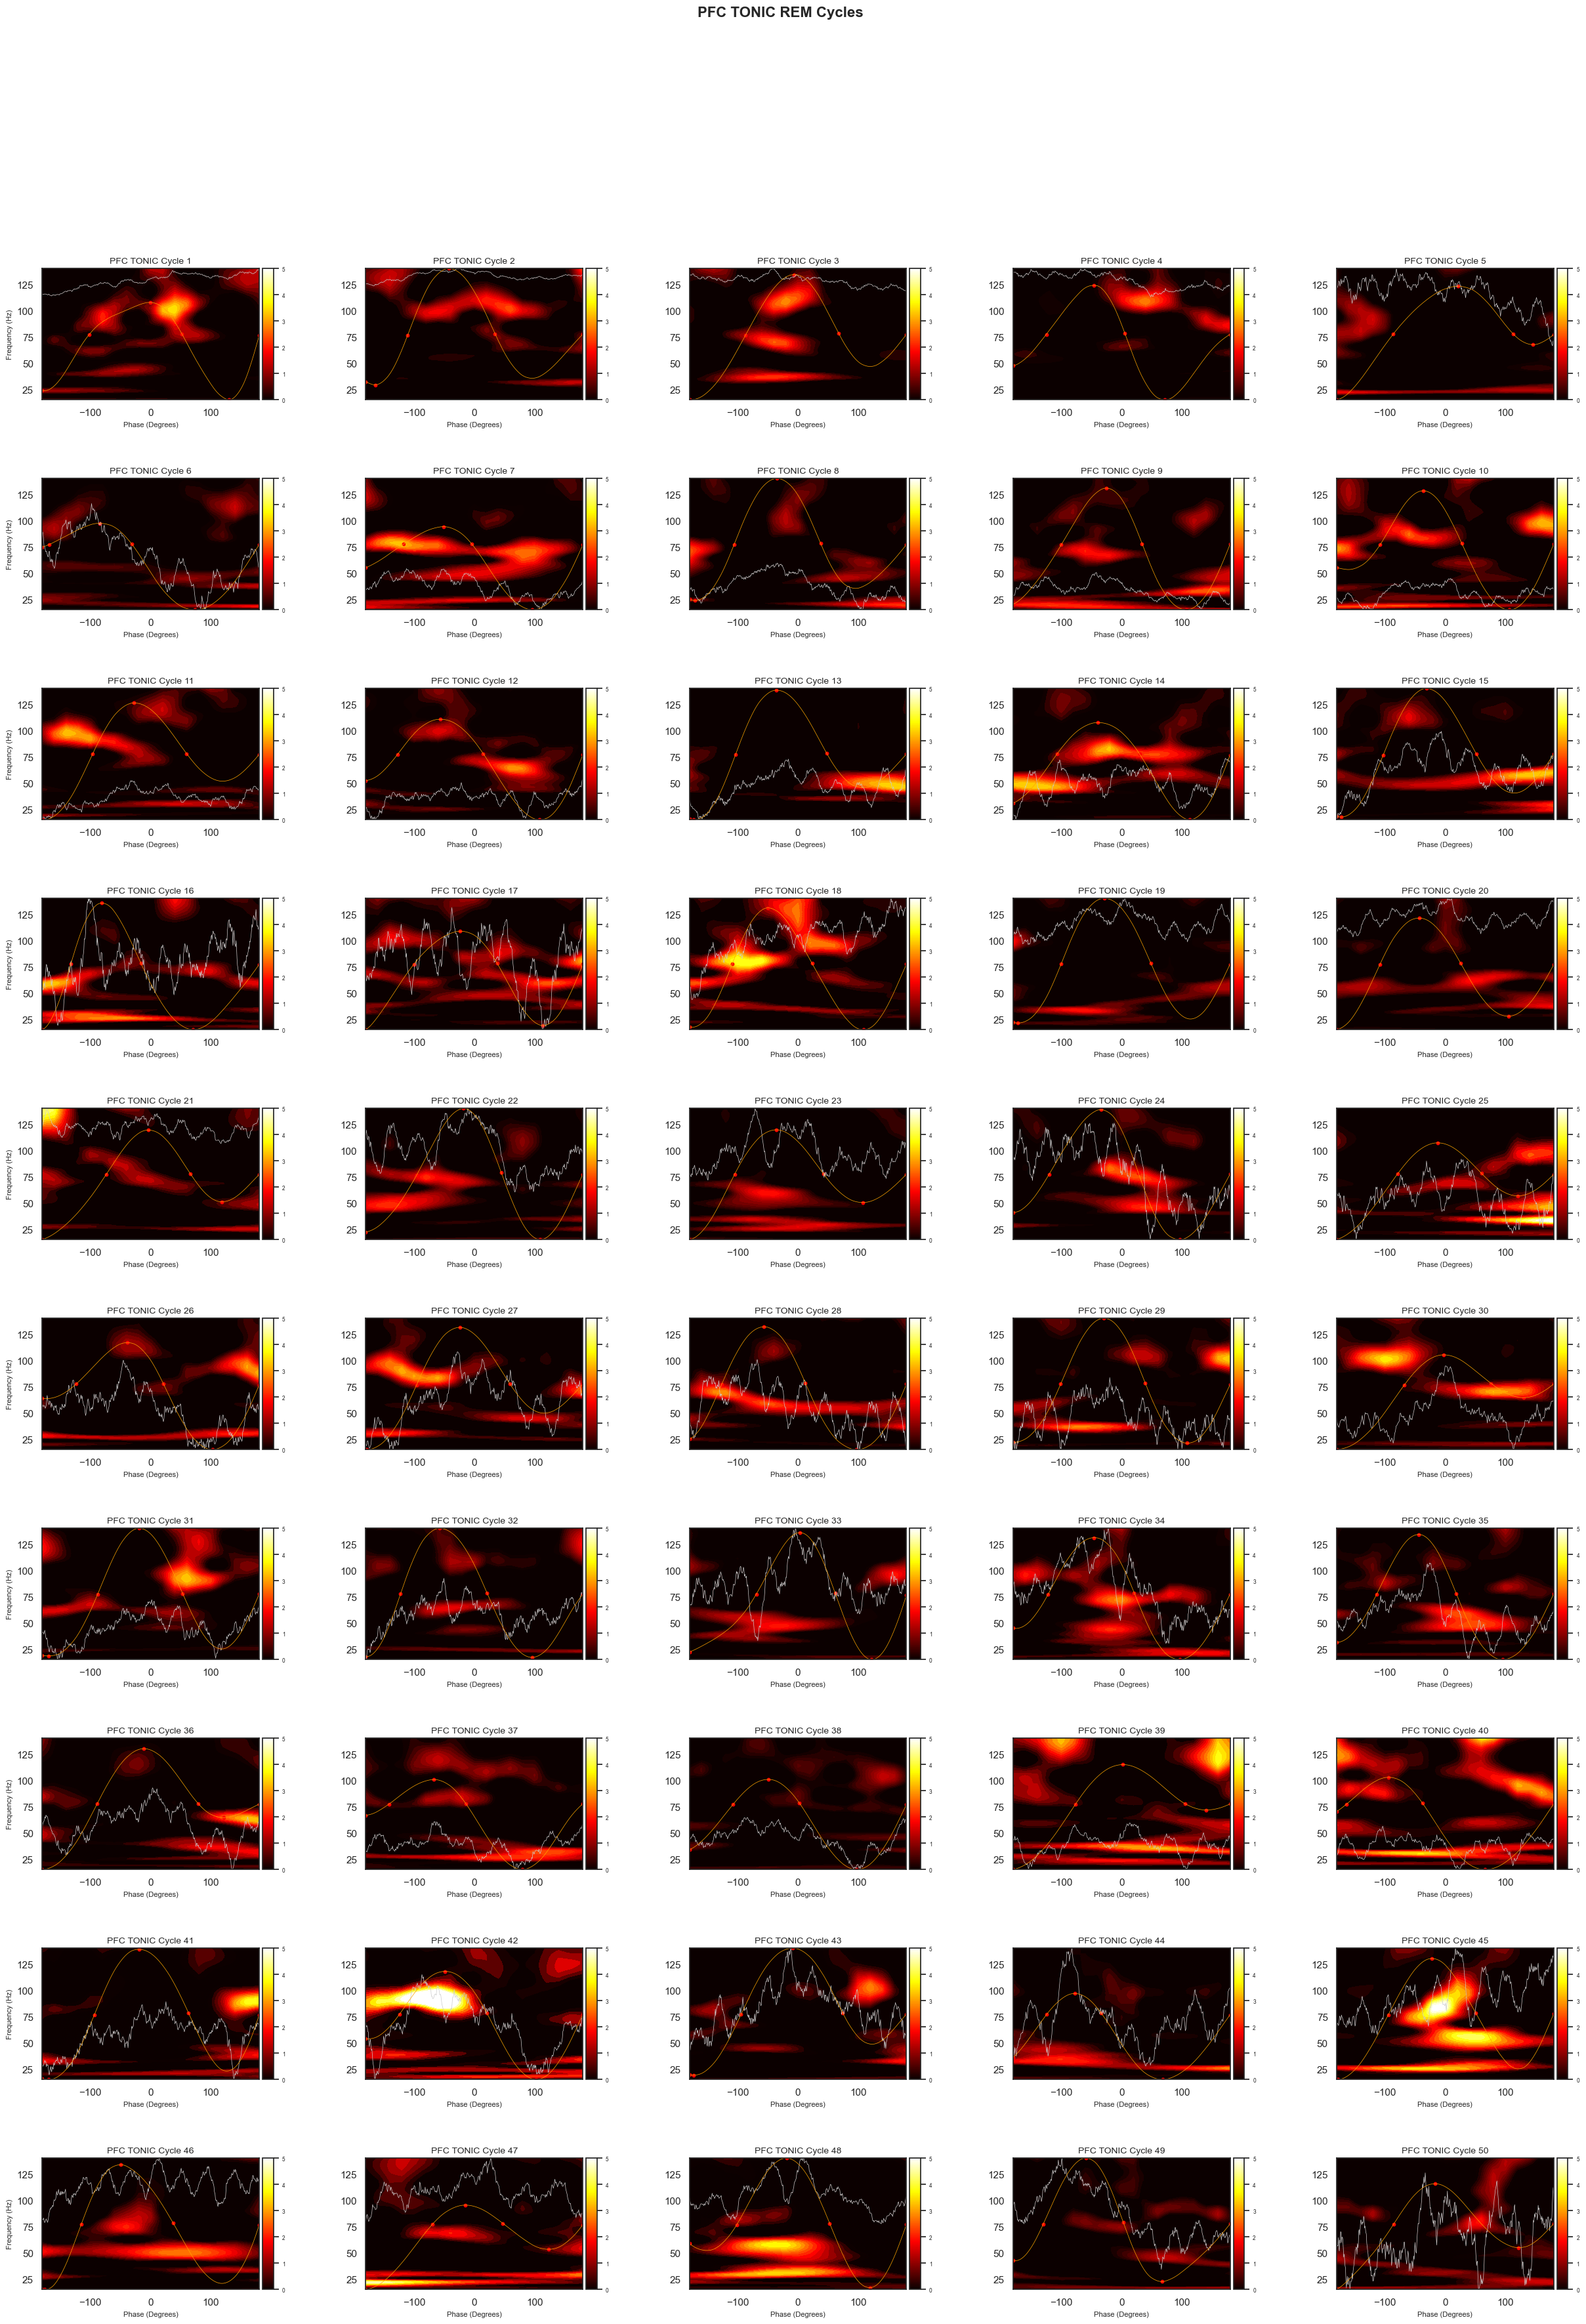

In [20]:
# For PFC PHASIC cycles (use all_phasic_* variables)
# OR for PFC TONIC cycles (use all_tonic_* variables)

# Choose one:
use_phasic = False  # Set to False for tonic

if use_phasic:
    FPP_source = all_phasic_FPPs
    cycles_se_source = all_phasic_cycles_se
    cycle_ctrls_source = all_phasic_cycle_ctrls
    imfs_source = phasic_imfs
    rem_lfp_source = rem_lpf
    title_type = "PHASIC"
else:
    FPP_source = all_tonic_FPPs
    cycles_se_source = all_tonic_cycles_se
    cycle_ctrls_source = all_tonic_cycle_ctrls
    imfs_source = tonic_imfs
    rem_lfp_source = tonic_rem_lpf
    title_type = "TONIC"

# Combine cycles from ALL intervals
all_combined_FPP = []
all_combined_cycles_inds = []
all_combined_cycles_ctrl = []
all_combined_imfs = []
all_combined_rem_lfp = []
all_cycle_to_interval_map = []

# Combine data from all intervals
for interval_idx in range(len(FPP_source)):
    for cycle_idx in range(len(FPP_source[interval_idx])):
        all_combined_FPP.append(FPP_source[interval_idx][cycle_idx])
        all_combined_cycles_inds.append(cycles_se_source[interval_idx][cycle_idx])
        all_combined_cycles_ctrl.append(cycle_ctrls_source[interval_idx][cycle_idx])
        all_combined_imfs.append(imfs_source[interval_idx])
        all_combined_rem_lfp.append(rem_lfp_source[interval_idx])
        all_cycle_to_interval_map.append(interval_idx)

print(f"Total PFC {title_type} cycles available: {len(all_combined_FPP)}")

# Set up for 50 cycles (10 rows x 5 columns)
n_rows, n_cols = 10, 5
max_plots = n_rows * n_cols

vmin = 0
vmax = 5
n_levels = 20

# Create a larger figure for 50 cycles
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 40))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

axes_flat = axes.flatten()

for ii in range(min(len(all_combined_FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]
    
    FPP_cycle = all_combined_FPP[ii]
    cycles_inds = all_combined_cycles_inds[ii]
    cycles_ctrl = all_combined_cycles_ctrl[ii]
    imf_full = all_combined_imfs[ii]
    rem_lfp_full = all_combined_rem_lfp[ii]
    
    levels = np.linspace(np.min(FPP_cycle), np.max(FPP_cycle), n_levels)
    im = ax.contourf(angles, frequencies, FPP_cycle, levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=8)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=8)
    ax.set_title(f"PFC {title_type} Cycle {ii+1}", fontsize=10)
    
    xinds = np.arange(len(cycles_inds))
    raw_lfp = rem_lfp_full[cycles_inds]
    theta_part = imf_full[cycles_inds, 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP', linewidth=0.5)
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6', linewidth=0.5)

    ctrl_points_x = np.interp(cycles_ctrl, np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[cycles_ctrl] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', s=10, label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax)
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=6)

if len(all_combined_FPP) < max_plots:
    for jj in range(len(all_combined_FPP), max_plots):
        fig.delaxes(axes_flat[jj])

plt.suptitle(f"PFC {title_type} REM Cycles", fontsize=16, fontweight='bold')
plt.show()

Total PFC PHASIC cycles available: 53


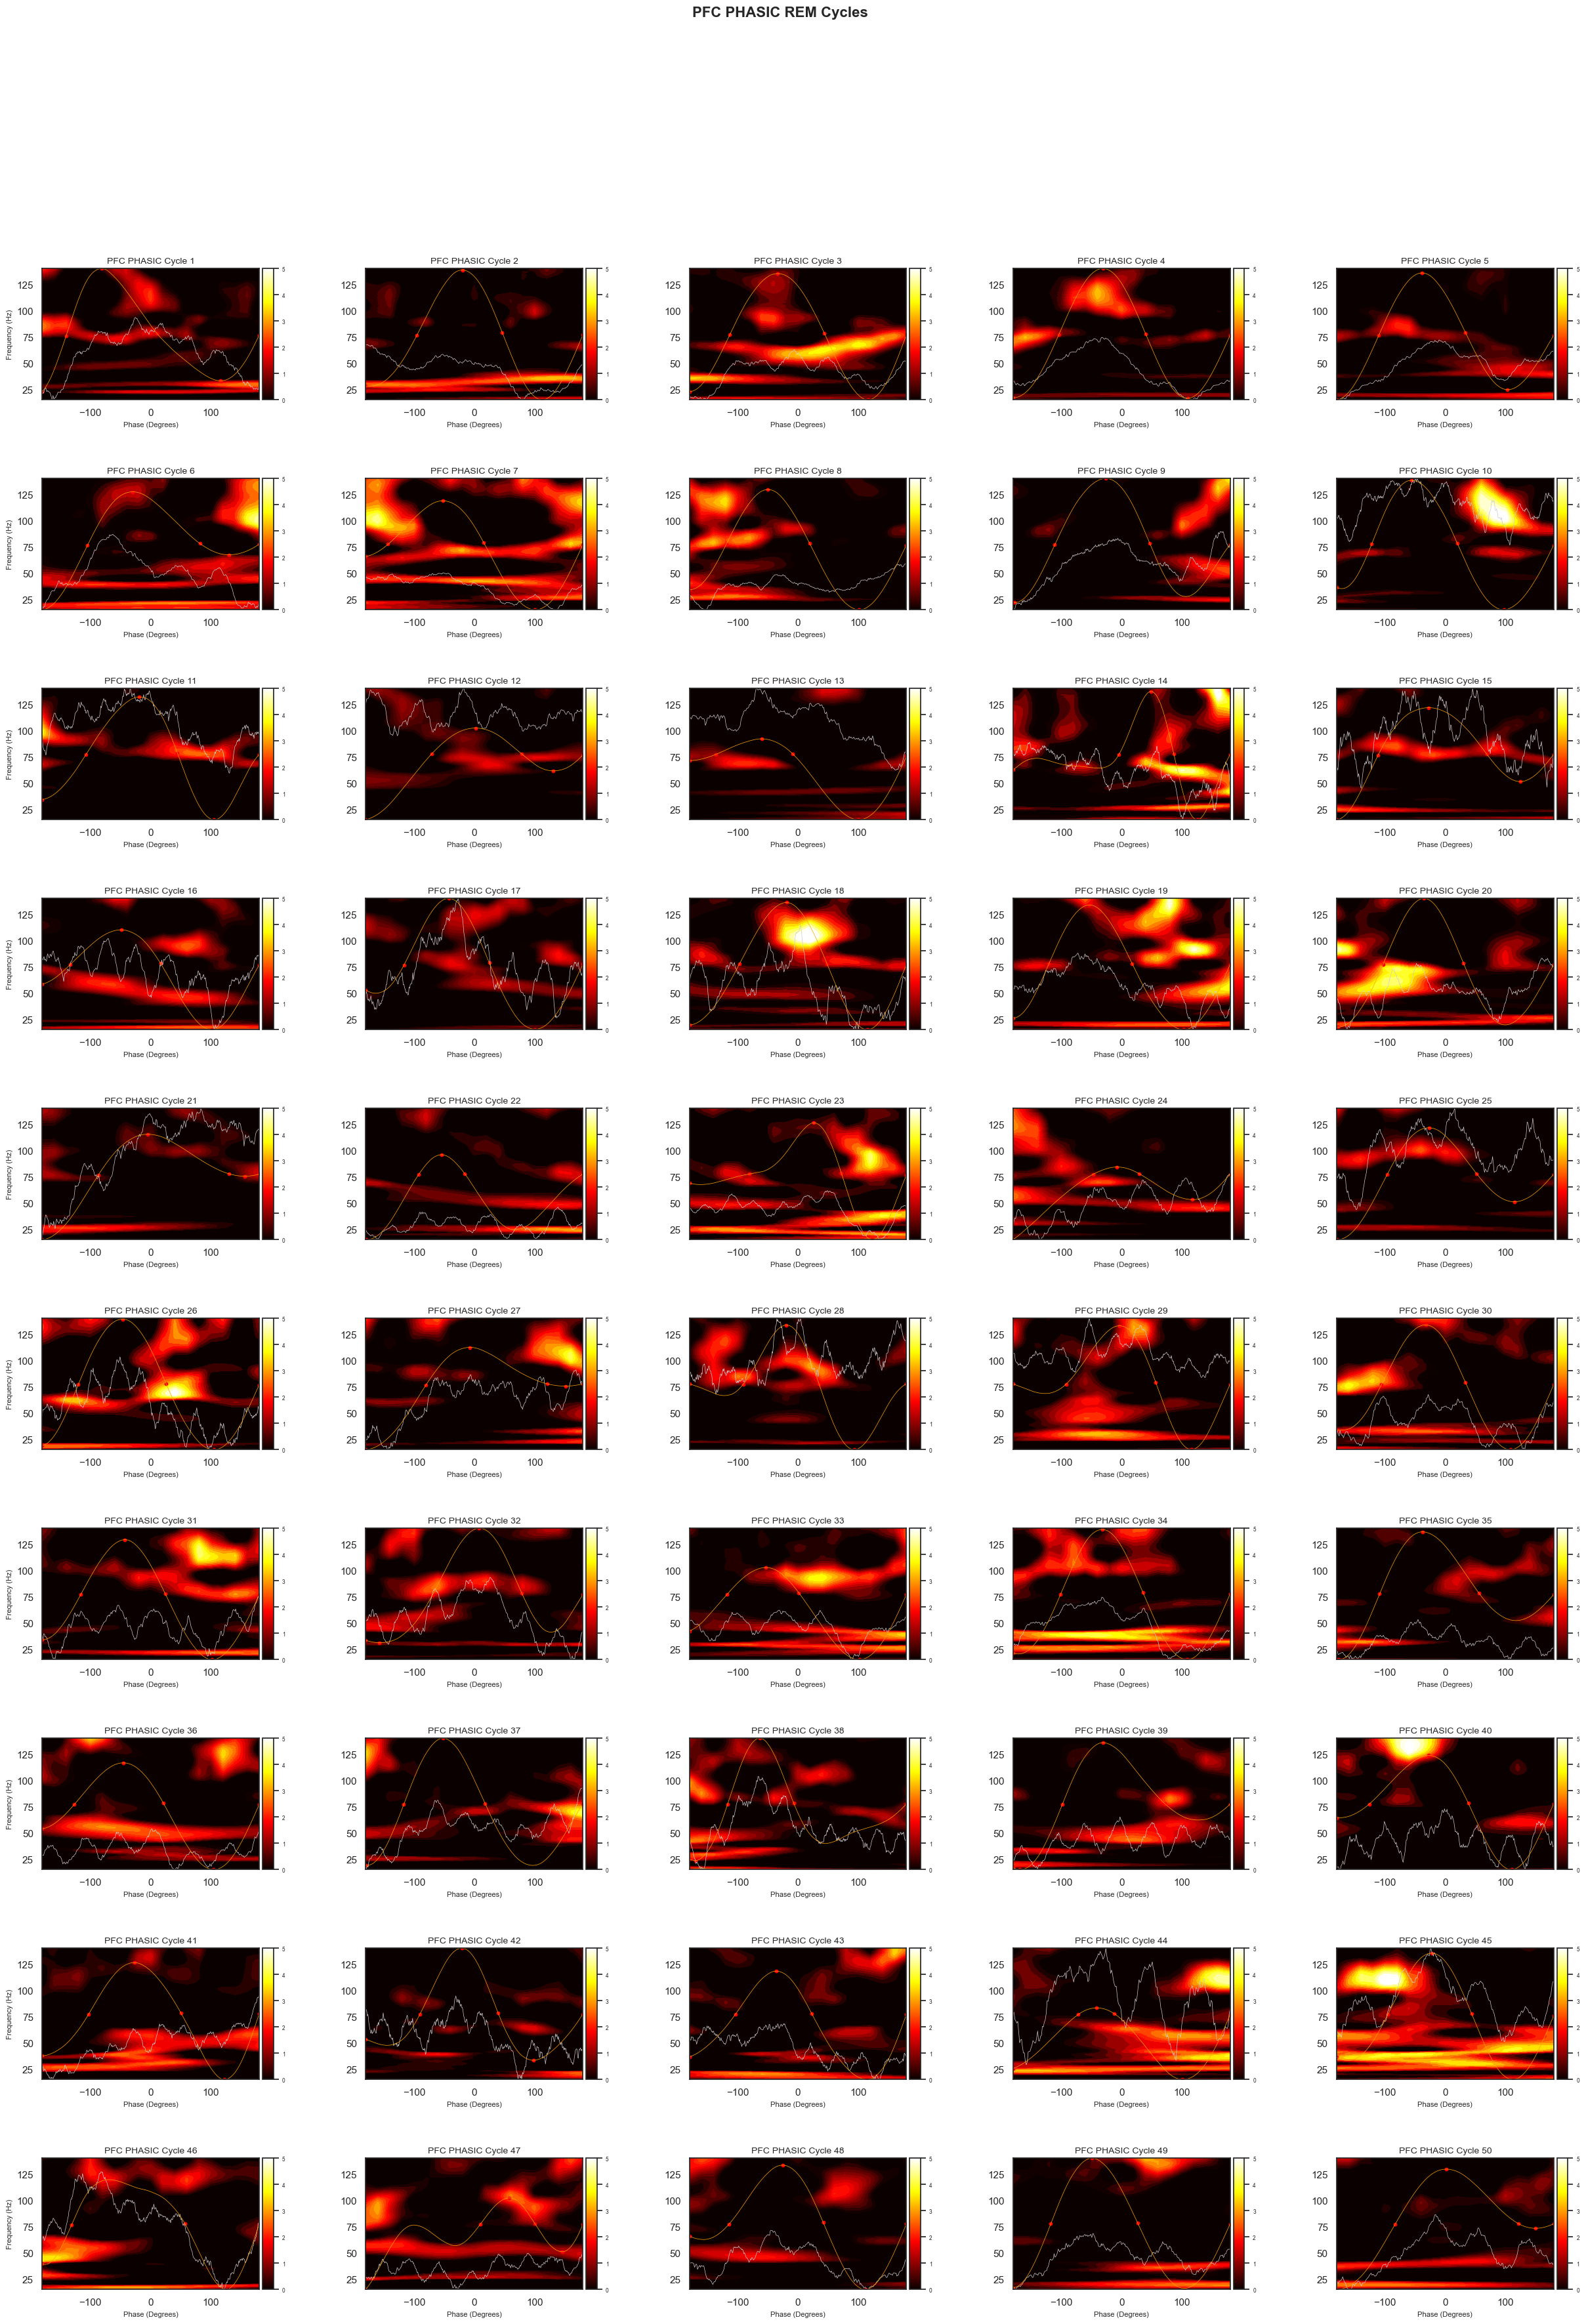

In [21]:
# For PFC PHASIC cycles (use all_phasic_* variables)
# OR for PFC TONIC cycles (use all_tonic_* variables)

# Choose one:
use_phasic = True  # Set to False for tonic

if use_phasic:
    FPP_source = all_phasic_FPPs
    cycles_se_source = all_phasic_cycles_se
    cycle_ctrls_source = all_phasic_cycle_ctrls
    imfs_source = phasic_imfs
    rem_lfp_source = rem_lpf
    title_type = "PHASIC"
else:
    FPP_source = all_tonic_FPPs
    cycles_se_source = all_tonic_cycles_se
    cycle_ctrls_source = all_tonic_cycle_ctrls
    imfs_source = tonic_imfs
    rem_lfp_source = tonic_rem_lpf
    title_type = "TONIC"

# Combine cycles from ALL intervals
all_combined_FPP = []
all_combined_cycles_inds = []
all_combined_cycles_ctrl = []
all_combined_imfs = []
all_combined_rem_lfp = []
all_cycle_to_interval_map = []

# Combine data from all intervals
for interval_idx in range(len(FPP_source)):
    for cycle_idx in range(len(FPP_source[interval_idx])):
        all_combined_FPP.append(FPP_source[interval_idx][cycle_idx])
        all_combined_cycles_inds.append(cycles_se_source[interval_idx][cycle_idx])
        all_combined_cycles_ctrl.append(cycle_ctrls_source[interval_idx][cycle_idx])
        all_combined_imfs.append(imfs_source[interval_idx])
        all_combined_rem_lfp.append(rem_lfp_source[interval_idx])
        all_cycle_to_interval_map.append(interval_idx)

print(f"Total PFC {title_type} cycles available: {len(all_combined_FPP)}")

# Set up for 50 cycles (10 rows x 5 columns)
n_rows, n_cols = 10, 5
max_plots = n_rows * n_cols

vmin = 0
vmax = 5
n_levels = 20

# Create a larger figure for 50 cycles
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 40))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

axes_flat = axes.flatten()

for ii in range(min(len(all_combined_FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]
    
    FPP_cycle = all_combined_FPP[ii]
    cycles_inds = all_combined_cycles_inds[ii]
    cycles_ctrl = all_combined_cycles_ctrl[ii]
    imf_full = all_combined_imfs[ii]
    rem_lfp_full = all_combined_rem_lfp[ii]
    
    levels = np.linspace(np.min(FPP_cycle), np.max(FPP_cycle), n_levels)
    im = ax.contourf(angles, frequencies, FPP_cycle, levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=8)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=8)
    ax.set_title(f"PFC {title_type} Cycle {ii+1}", fontsize=10)
    
    xinds = np.arange(len(cycles_inds))
    raw_lfp = rem_lfp_full[cycles_inds]
    theta_part = imf_full[cycles_inds, 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP', linewidth=0.5)
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6', linewidth=0.5)

    ctrl_points_x = np.interp(cycles_ctrl, np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[cycles_ctrl] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', s=10, label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax)
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=6)

if len(all_combined_FPP) < max_plots:
    for jj in range(len(all_combined_FPP), max_plots):
        fig.delaxes(axes_flat[jj])

plt.suptitle(f"PFC {title_type} REM Cycles", fontsize=16, fontweight='bold')
plt.show()